# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=False)

In [38]:
import pandas as pd
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
import shap
import matplotlib.pyplot as plt

from create_prediction import create_prediction
from draw_and_create_clusters import create_kmeans_clusters 
from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from create_target_columns import create_target_columns
from prepare_and_scale_data import prepare_and_scale_data
from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals
from print_examples import create_example_df, plot_difference
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the TensorBoard notebook extension
%load_ext tensorboard

pd.options.display.max_colwidth = 100







The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:

list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']

target_col_start = 'Äänet yhteensä lkm'
target = create_target_columns(list_of_parties, target_col_start)


In [6]:



#set values to feature engineering attributes

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'
test_size = 0.3
#Scalers attributes
kbest_score_func = mutual_info_regression 

metric = 'rmse'
Skfold=False
Verbose = False
testing=True
scaled = False



In [7]:


shap_values = []
shap_interaction_values = []
shap_expected_value = []

mymodel = {}
features_dict = {}
importance_dict = {}

data, X_scale, X = prepare_and_scale_data(stat, pd.DataFrame(), numeric_features=numeric_features, categorical_features=categorical_features)

i = 0
for t in target:
    params = {
        #Initial xgboost parameters to be automatically tuned
        'objective':'reg:squarederror',
        'booster' : 'gbtree',
        'eval_metric' : metric
        }
    d = pd.DataFrame()
    test = pd.DataFrame()
    filename_model = 'xgboost_political' + t
    print(t)
    d, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model,
                          path,
                          stat,
                          stat,
                          t,
                          kbest_score_func=kbest_score_func,
                          metric=metric,
                          params= params,
                          numeric_features=numeric_features,
                          categorical_features=categorical_features,
                          scaled=scaled,
                          k_selected = k_selected,
                          test_size = test_size,
                          Skfold=Skfold,
                          Verbose = Verbose,
                          testing=testing)
    
    
    data.loc[:,"Ennustettu "+ t] = y_pred
    
    filename_model = 'xgboost_political_shap' + t
    filename_shap =  'political_shap_shap' + t +'.npz'
    mymod, sh_values, shap_i_values, shap_e_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


    shap_values.append(sh_values)
    shap_interaction_values.append(shap_i_values)
    shap_expected_value.append(shap_e_value.item())
    
    mymodel[t] = mymod
    features_dict[t] = features_df
    importance_dict[t] = importance_df



Äänet yhteensä lkm VIHR
load model
load model
load shap files
Äänet yhteensä lkm KOK
load model
load model
load shap files
Äänet yhteensä lkm SDP
load model
load model
load shap files
Äänet yhteensä lkm KD
load model
load model
load shap files
Äänet yhteensä lkm KESK
load model
load model
load shap files
Äänet yhteensä lkm RKP
load model
load model
load shap files
Äänet yhteensä lkm PS
load model
load model
load shap files
Äänet yhteensä lkm VAS
load model
load model
load shap files


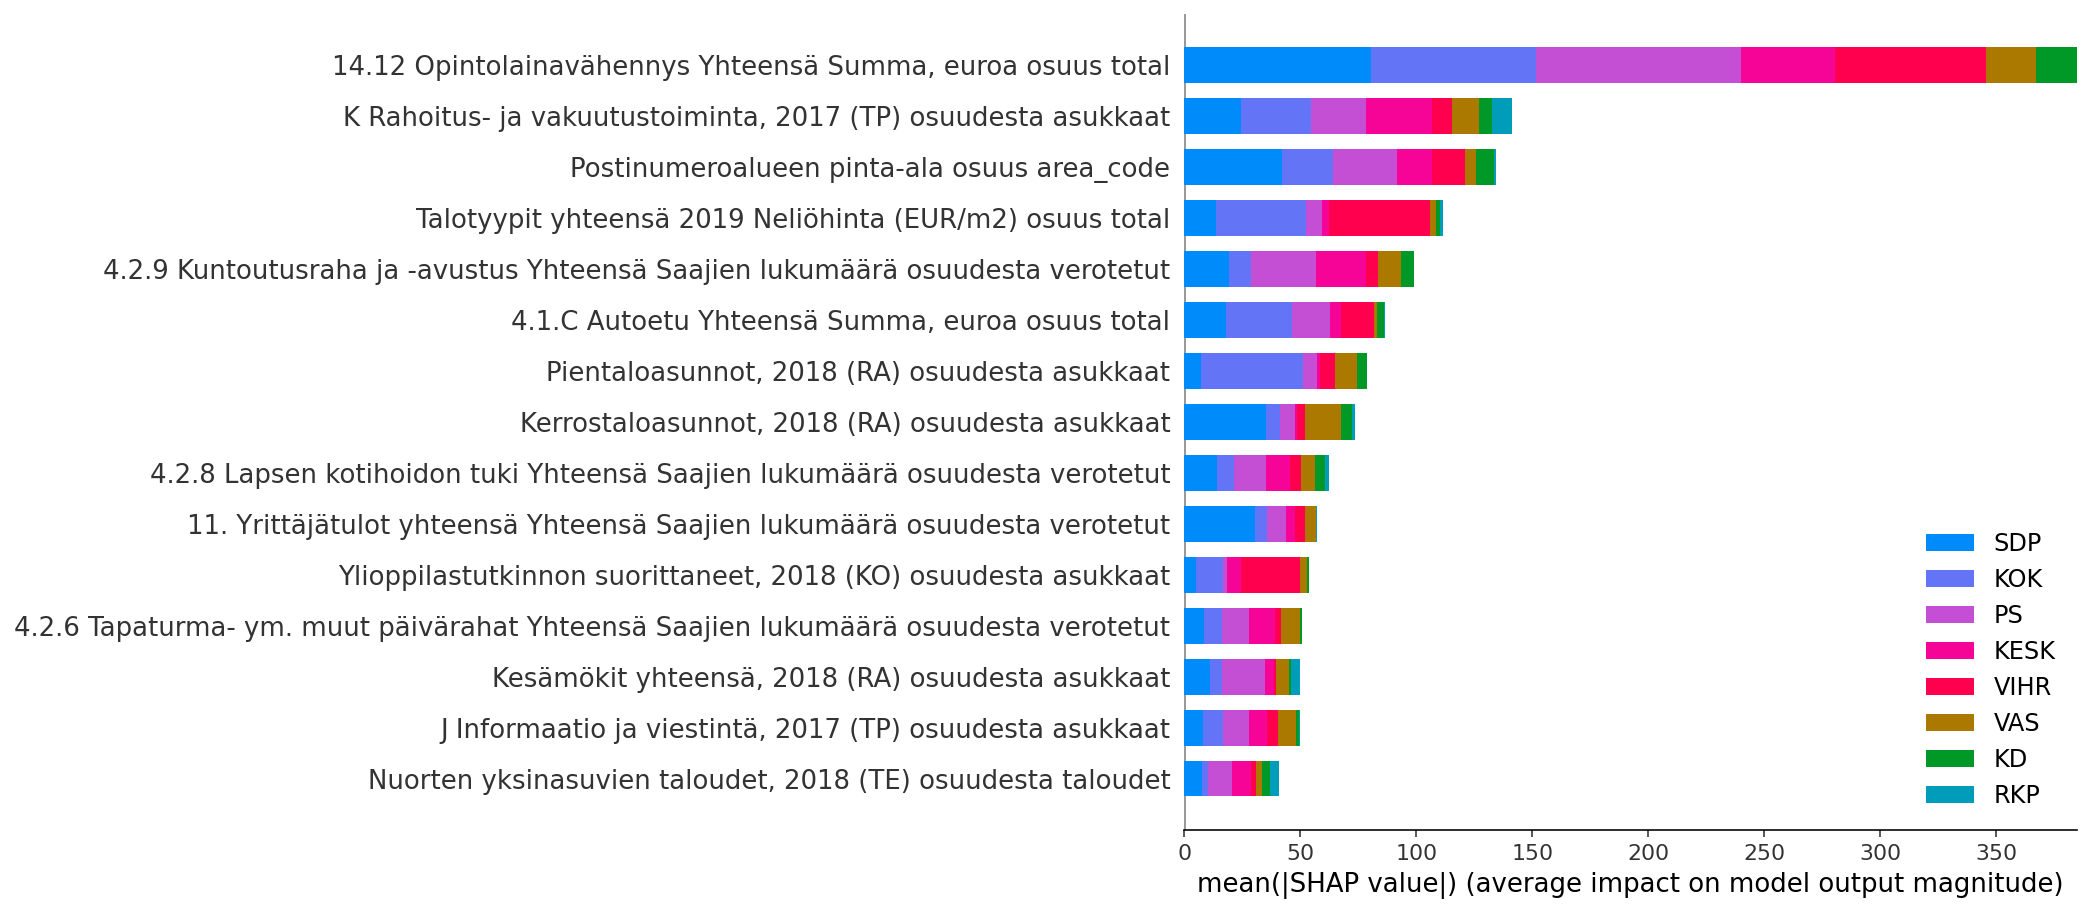

In [8]:
shap.summary_plot(shap_values, X,  max_display=15 ,class_names = list_of_parties)

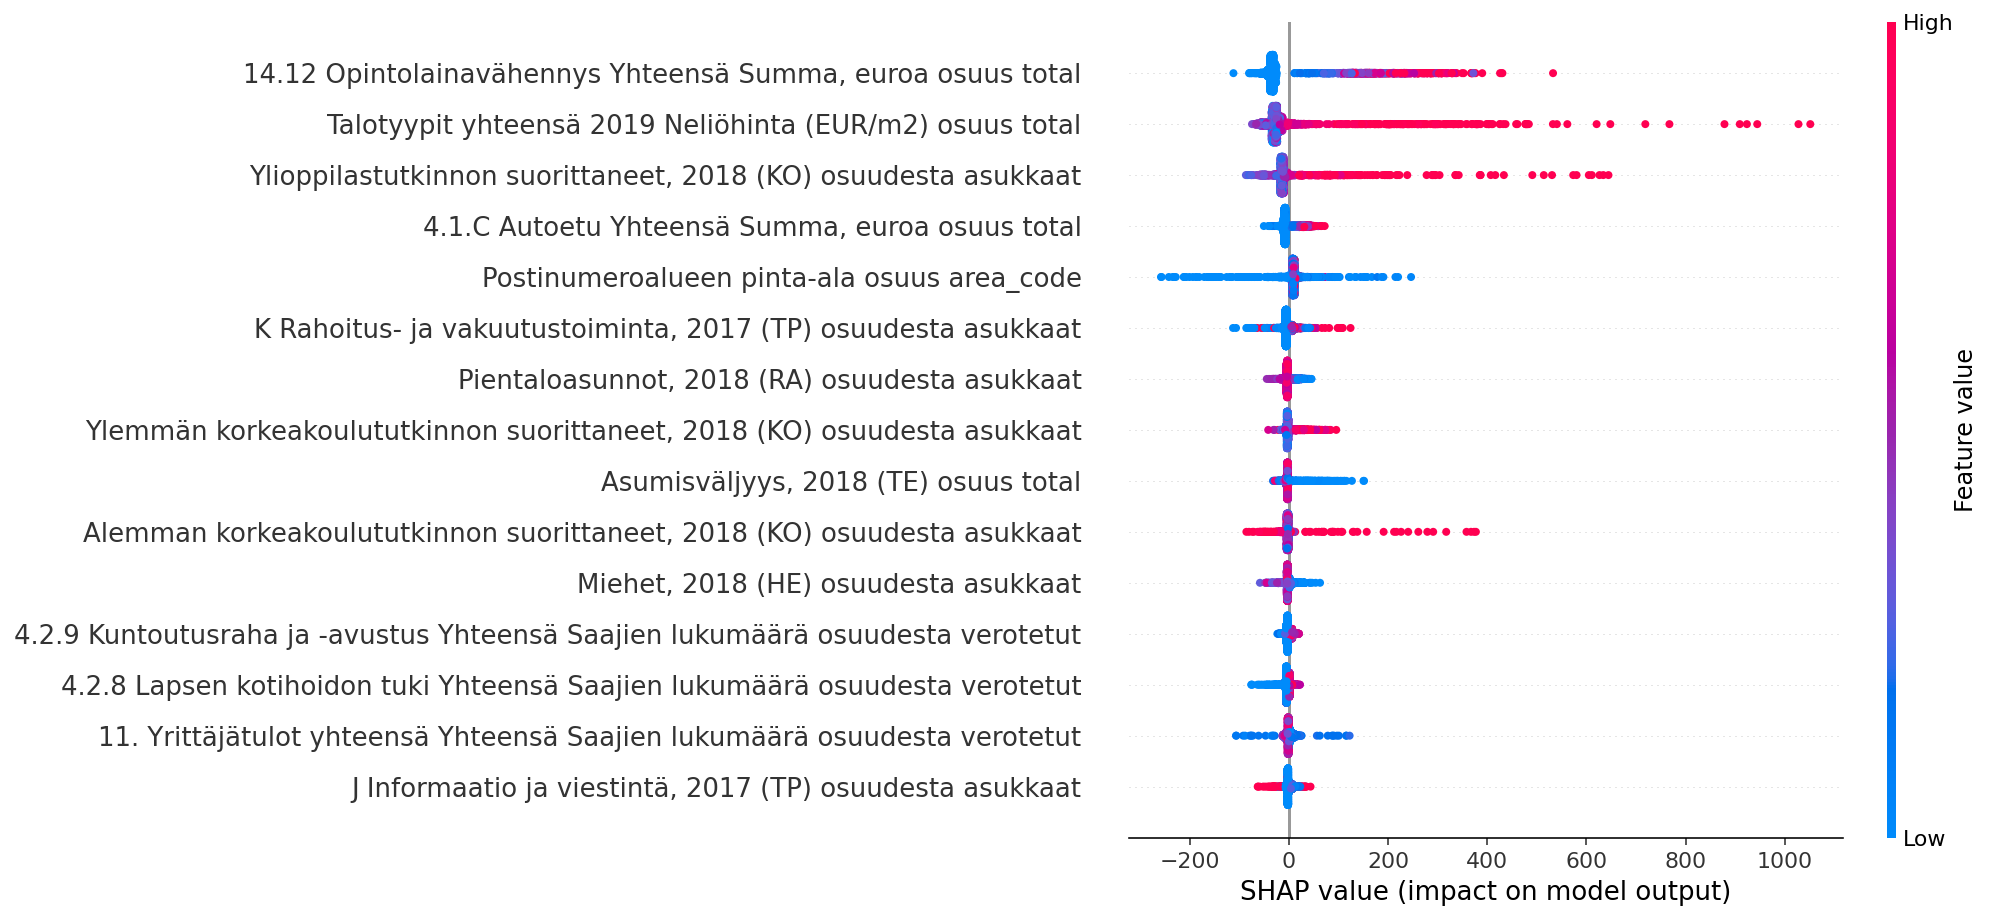

In [9]:
party ='VIHR'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


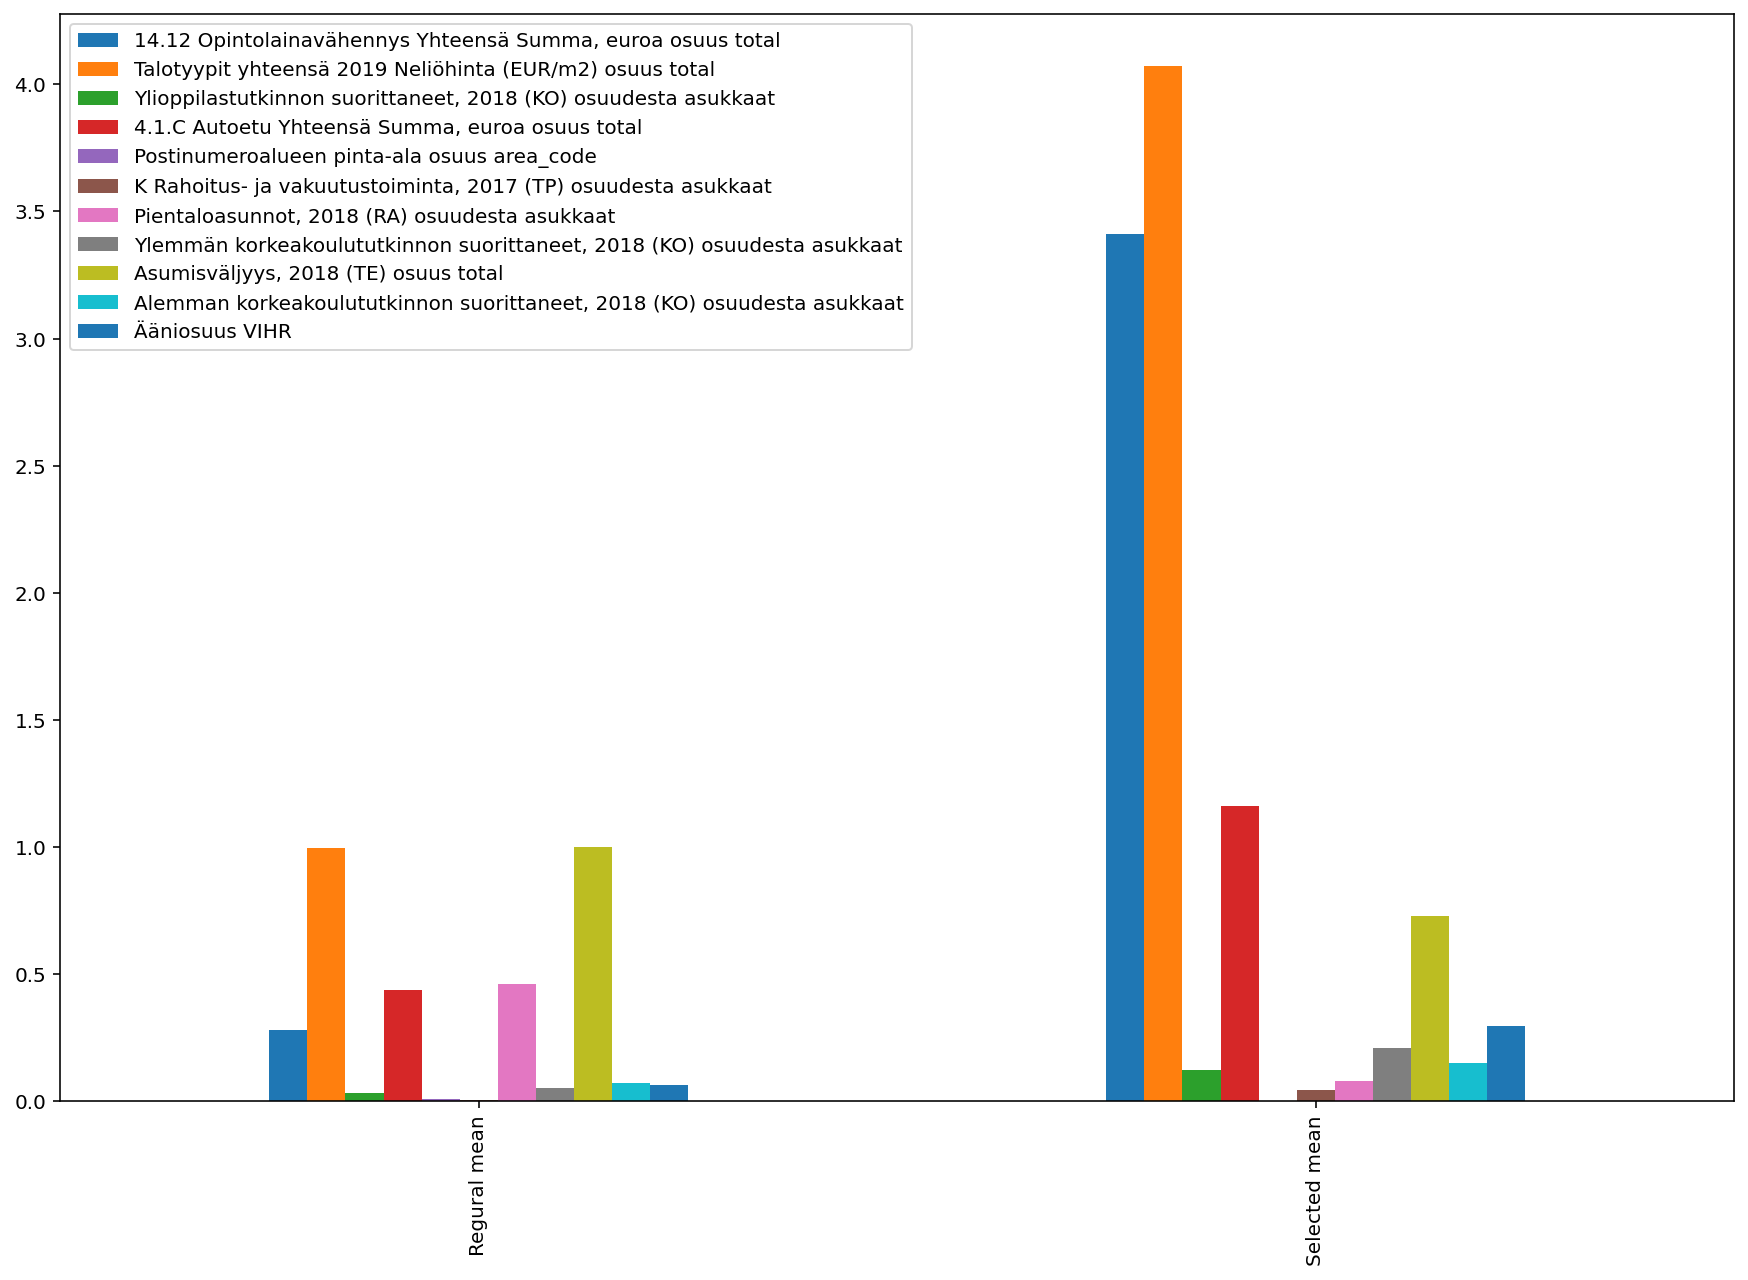

In [10]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [11]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2963       99885    LEMMENJOKI            Inari                          51.0   
34         00520      HELSINKI         Helsinki                        7276.0   
135        02110         ESPOO            Espoo                        2779.0   
6          00170      HELSINKI         Helsinki                        7495.0   
32         00500      HELSINKI         Helsinki                       12436.0   

     Suurin_puolue  Ääniosuus VIHR  \
2963          VIHR        0.269231   
34            VIHR        0.285624   
135            KOK        0.292962   
6              KOK        0.269646   
32            VIHR        0.338981   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
2963                                                  1.090774   
34                                                    4.250788   
135                                                   4.212813   
6                                                     5.970979   
32                                                    5.101592   

      Postinumeroalueen pinta-ala osuus area_code  \
2963                                     0.006032   
34                                       0.000166   
135                                      0.000093   
6                                        0.000075   
32                                       0.000062   

      Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2963                                                        0.058824   
34                                                          0.111325   
135                                                         0.107593   
6                                                           0.135690   
32                                                          0.167739   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2963                                                       0.000000   
34                                                         0.012782   
135                                                        0.000360   
6                                                          0.110740   
32                                                         0.252332   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  \
2963                                                     0.000000   
34                                                       3.889014   
135                                                      3.683360   
6                                                        4.632415   
32                                                       6.951847   

      4.1.C Autoetu Yhteensä Summa, euroa osuus total  
2963                                         0.000000  
34                                           0.936307  
135                                          1.768430  
6                                            2.397945  
32                                           0.499895

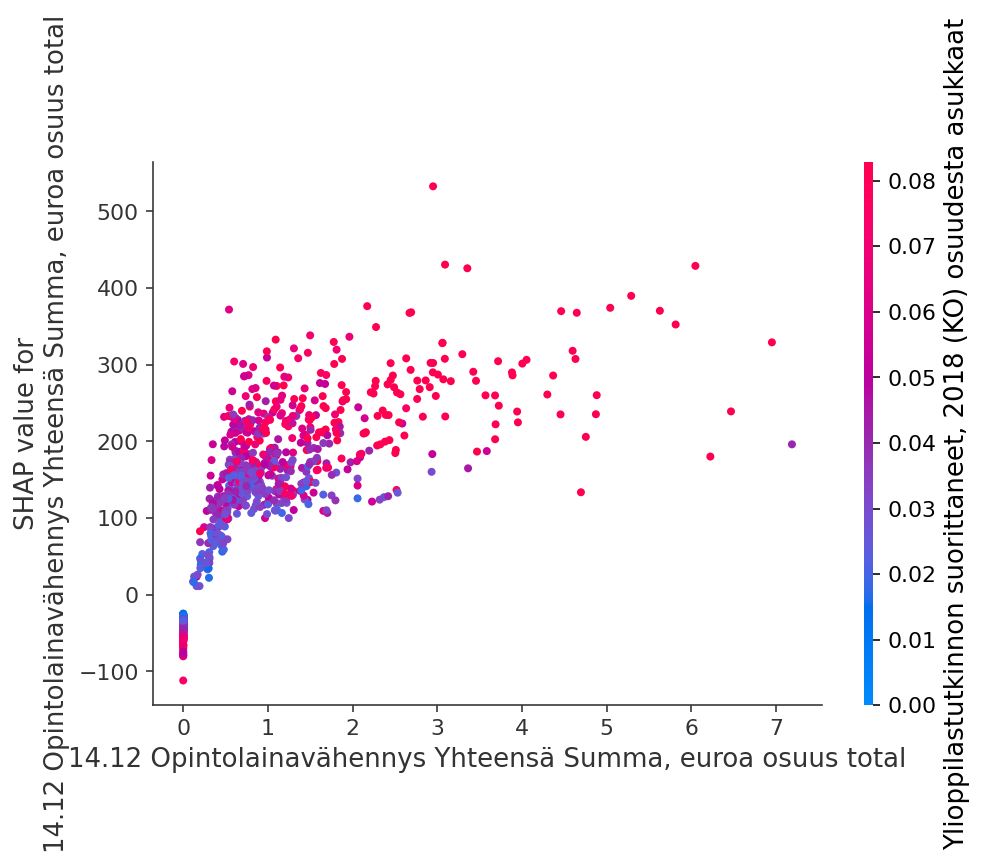

In [12]:
shap.dependence_plot("rank(0)", shap_values[shap_index], X)

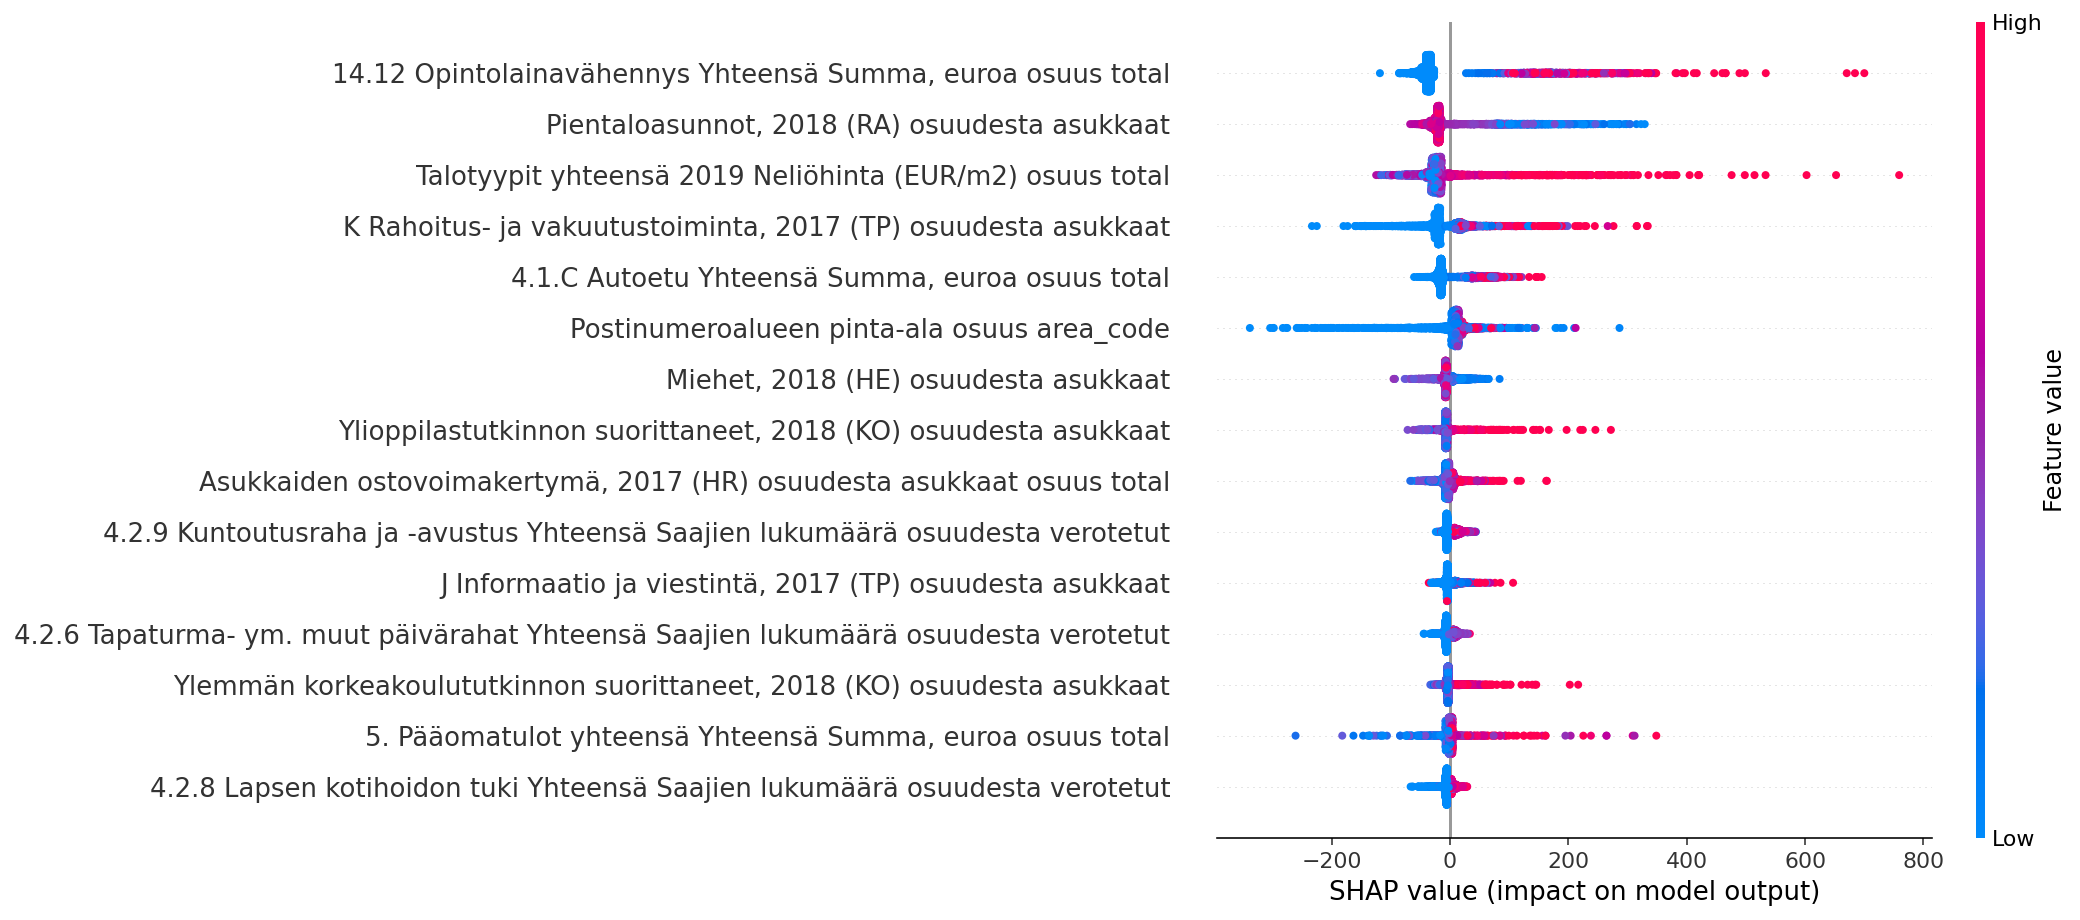

In [13]:
party ='KOK'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


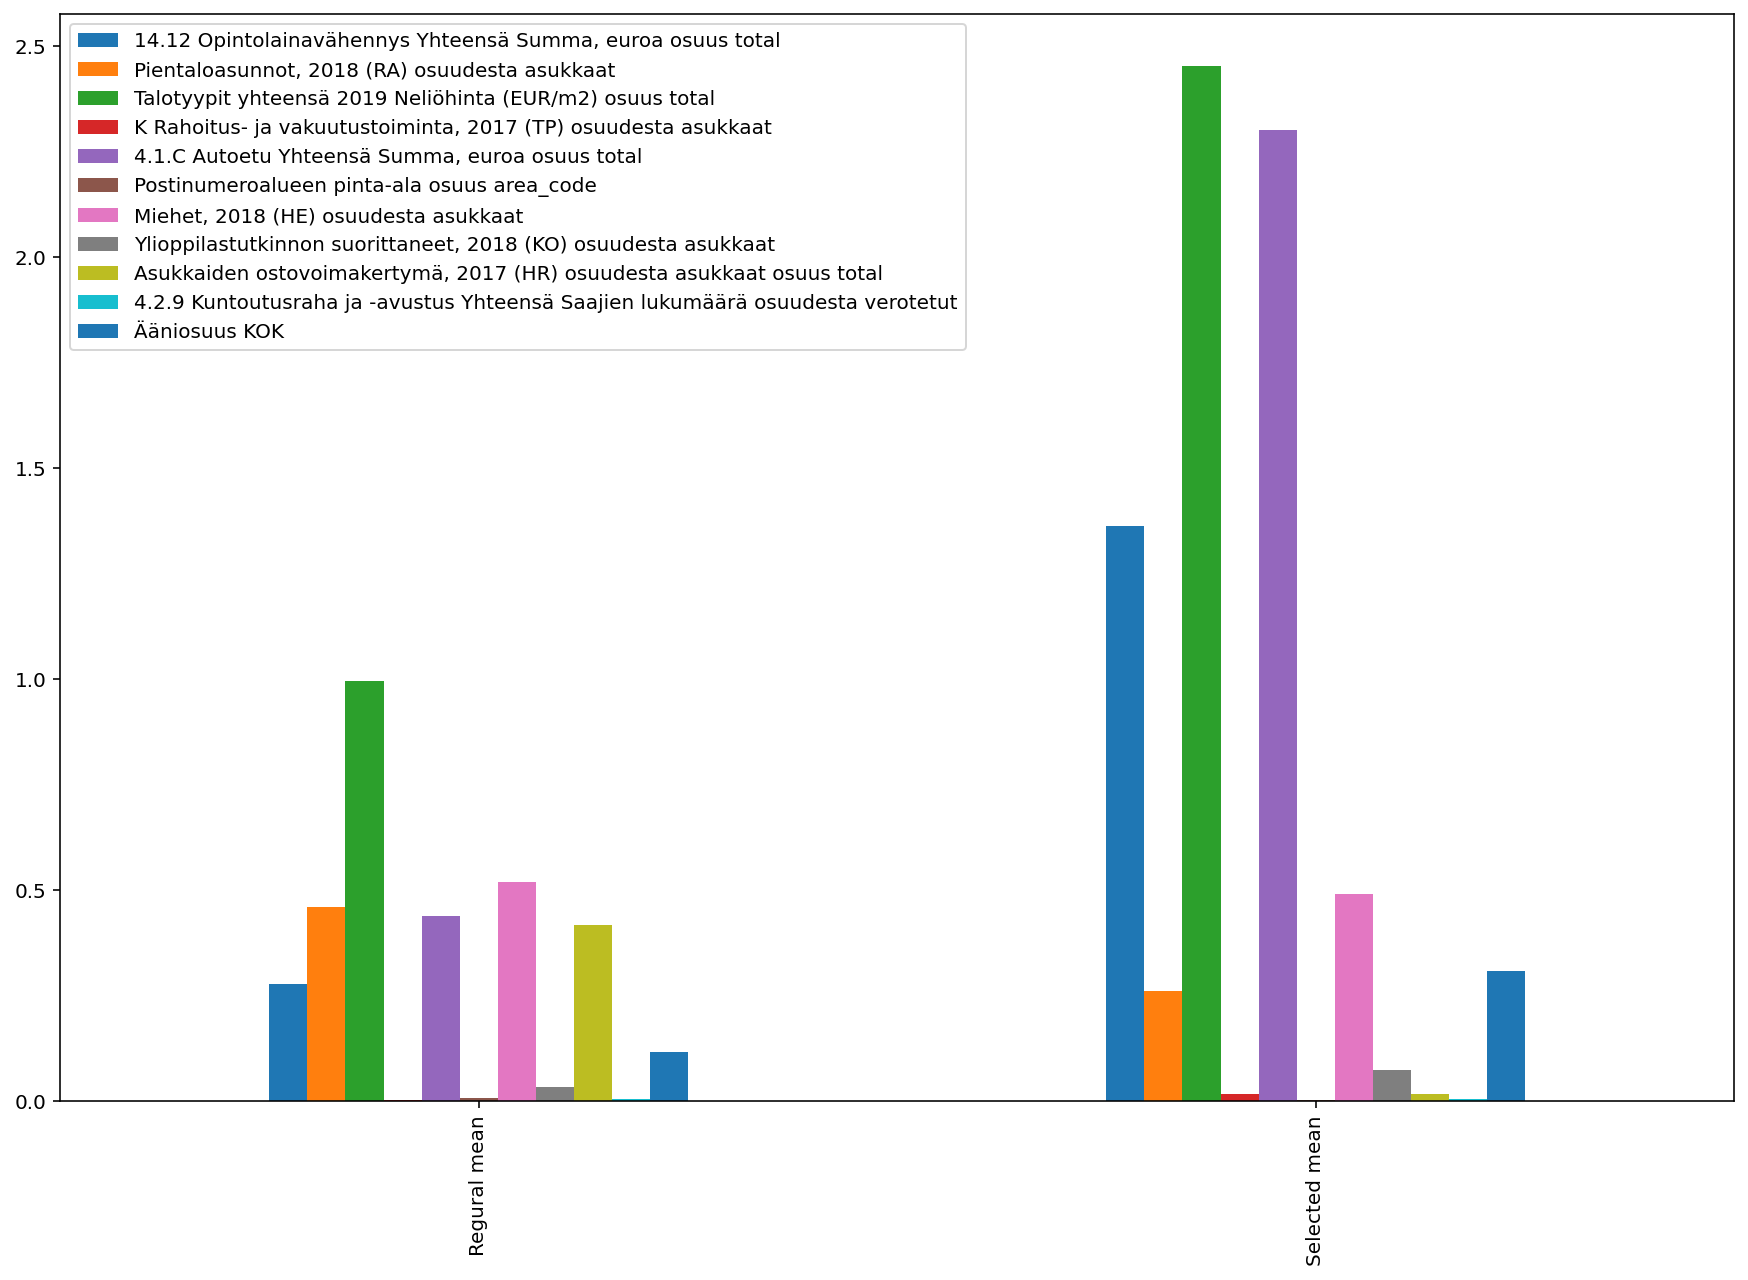

In [14]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [15]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
392        13100   HÄMEENLINNA      Hämeenlinna                       11271.0   
150        02280         ESPOO            Espoo                        4440.0   
642        21250         MASKU            Masku                        6569.0   
21         00340      HELSINKI         Helsinki                        1767.0   
1461       50130       MIKKELI          Mikkeli                        2979.0   

     Suurin_puolue  Ääniosuus KOK  \
392            KOK       0.255560   
150            KOK       0.299086   
642            KOK       0.258048   
21             KOK       0.460870   
1461           KOK       0.272838   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
392                                                   1.662825   
150                                                   2.868332   
642                                                   1.397807   
21                                                    3.722368   
1461                                                  1.506076   

      Postinumeroalueen pinta-ala osuus area_code  \
392                                      0.001070   
150                                      0.000356   
642                                      0.007766   
21                                       0.000107   
1461                                     0.000368   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
392                                        0.156951   
150                                        0.297297   
642                                        0.397473   
21                                         0.225241   
1461                                       0.294394   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
392                                                        0.024221   
150                                                        0.000000   
642                                                        0.006546   
21                                                         0.005093   
1461                                                       0.000336   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  \
392                                                      1.358090   
150                                                      1.422663   
642                                                      0.589240   
21                                                       1.511377   
1461                                                     0.820436   

      4.1.C Autoetu Yhteensä Summa, euroa osuus total  
392                                          1.016386  
150                                          2.381016  
642                                          2.129033  
21                                           6.299566  
1461                                         0.537603

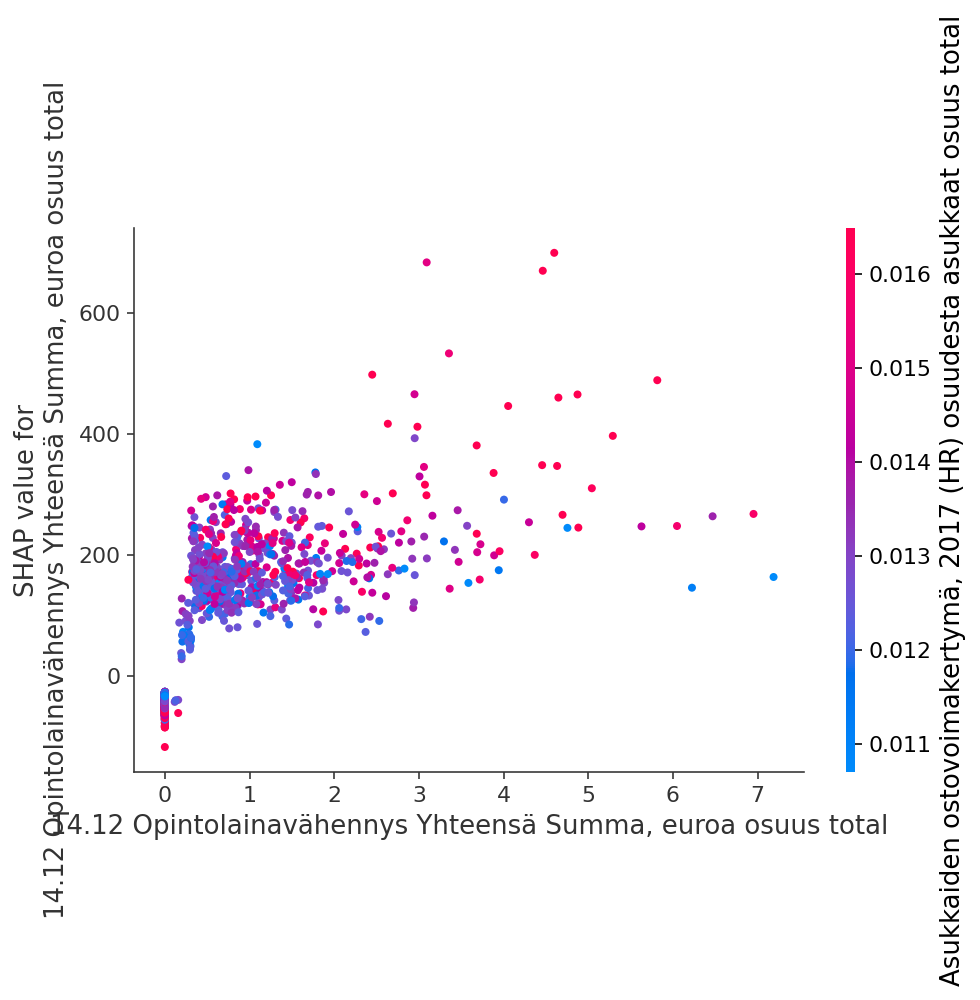

In [16]:
shap.dependence_plot("rank(0)", shap_values[shap_index], X)

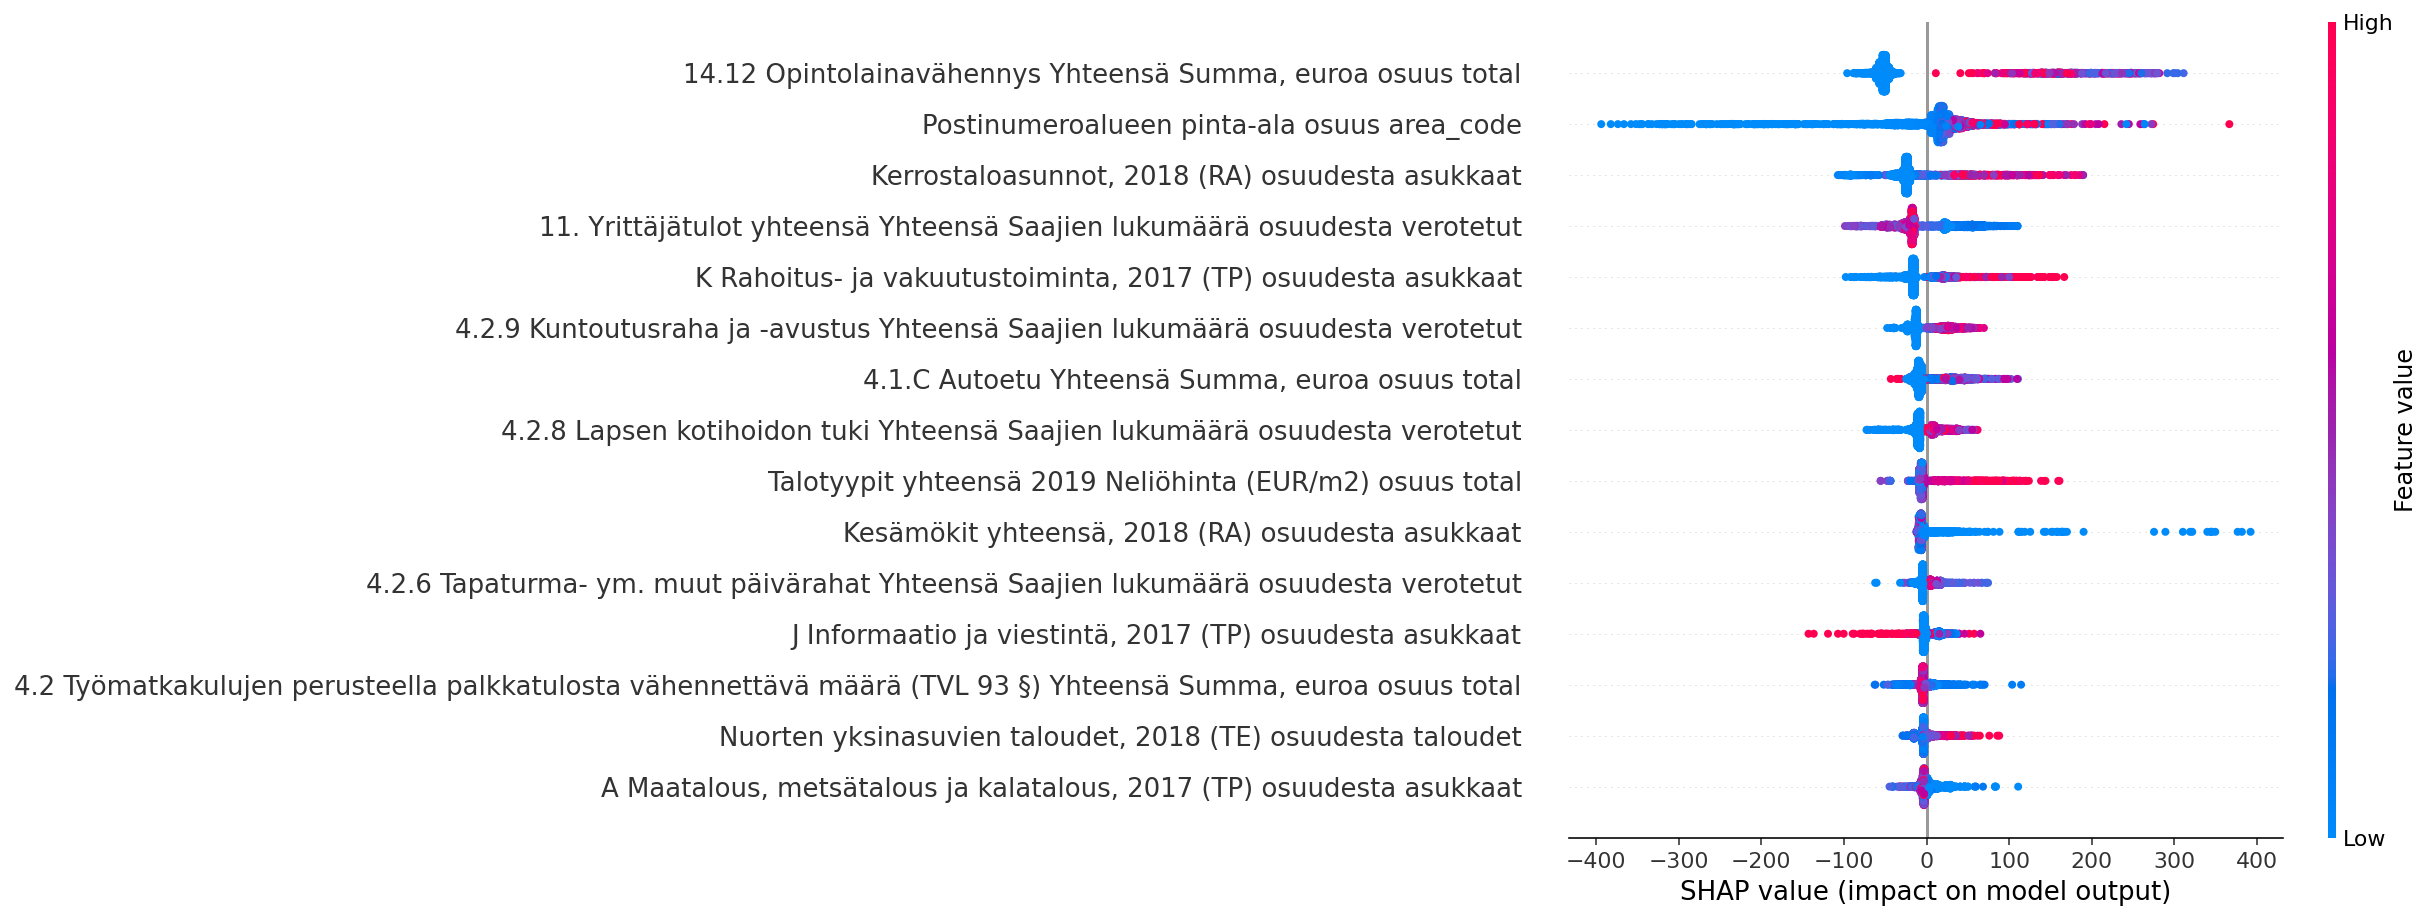

In [17]:
party ='SDP'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


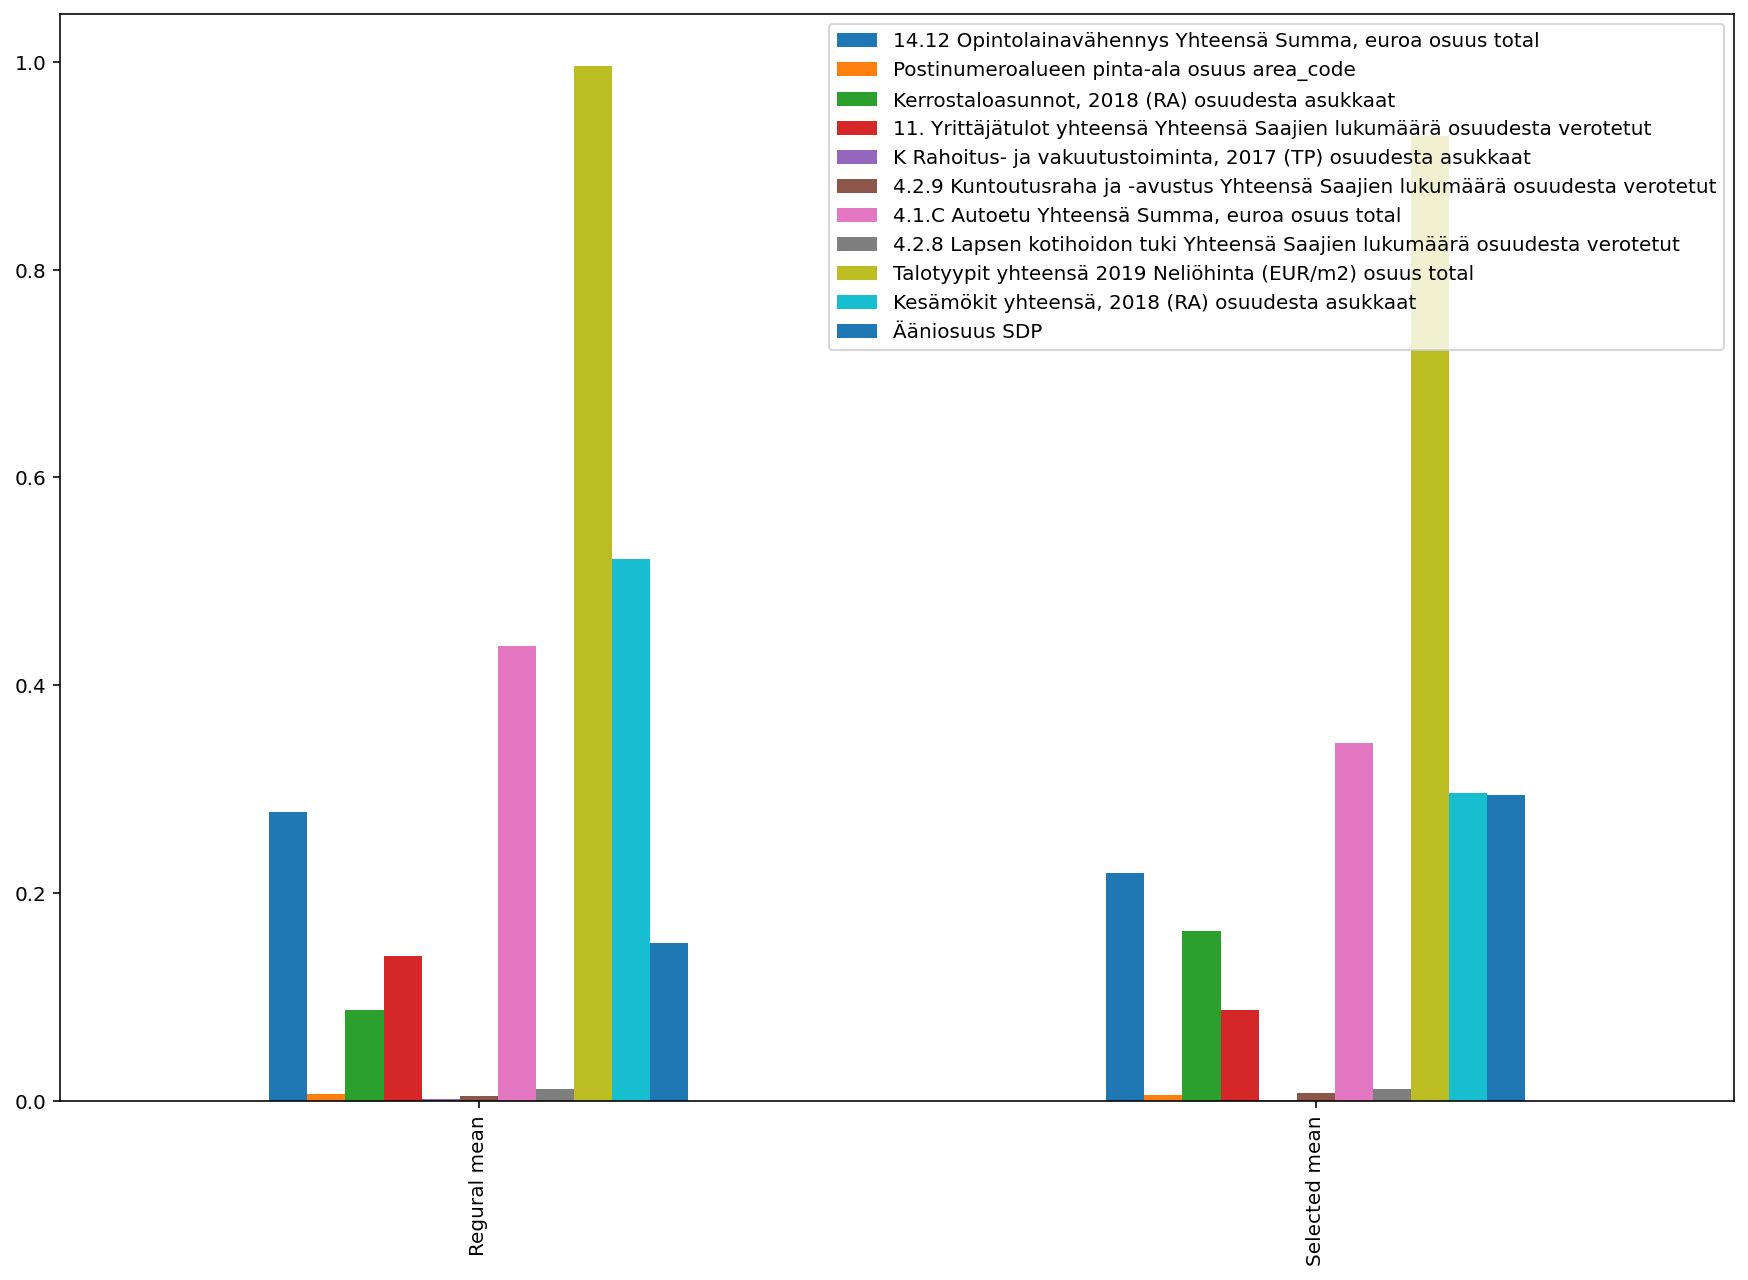

In [18]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [19]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1363       45940       ORAVALA          Kouvola                         285.0   
1574       55320         RAUHA     Lappeenranta                         563.0   
421        12400    TERVAKOSKI        Janakkala                        4574.0   
439        13800      KATINALA          Hattula                        1312.0   
208        03600      KARKKILA         Karkkila                        6419.0   

     Suurin_puolue  Ääniosuus SDP  \
1363           SDP       0.293040   
1574           SDP       0.259124   
421            SDP       0.272872   
439            SDP       0.265672   
208            SDP       0.261825   

      Postinumeroalueen pinta-ala osuus area_code  \
1363                                     0.004728   
1574                                     0.000759   
421                                      0.014964   
439                                      0.007922   
208                                      0.018071   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
1363                                         0.000000   
1574                                         0.175844   
421                                          0.180805   
439                                          0.061738   
208                                          0.193177   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
1363                                                       0.000000   
1574                                                       0.000000   
421                                                        0.001312   
439                                                        0.001524   
208                                                        0.003272   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
1363                                                                   0.114173   
1574                                                                   0.063918   
421                                                                    0.060115   
439                                                                    0.080573   
208                                                                    0.070637   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
1363                                                                        0.000000   
1574                                                                        0.022680   
421                                                                         0.010978   
439                                                                         0.008057   
208                                                                         0.008535   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  
1363                                                     0.000000  
1574                                                     0.000000  
421                                                      0.533262  
439                                                      0.000000  
208                                                      0.116739

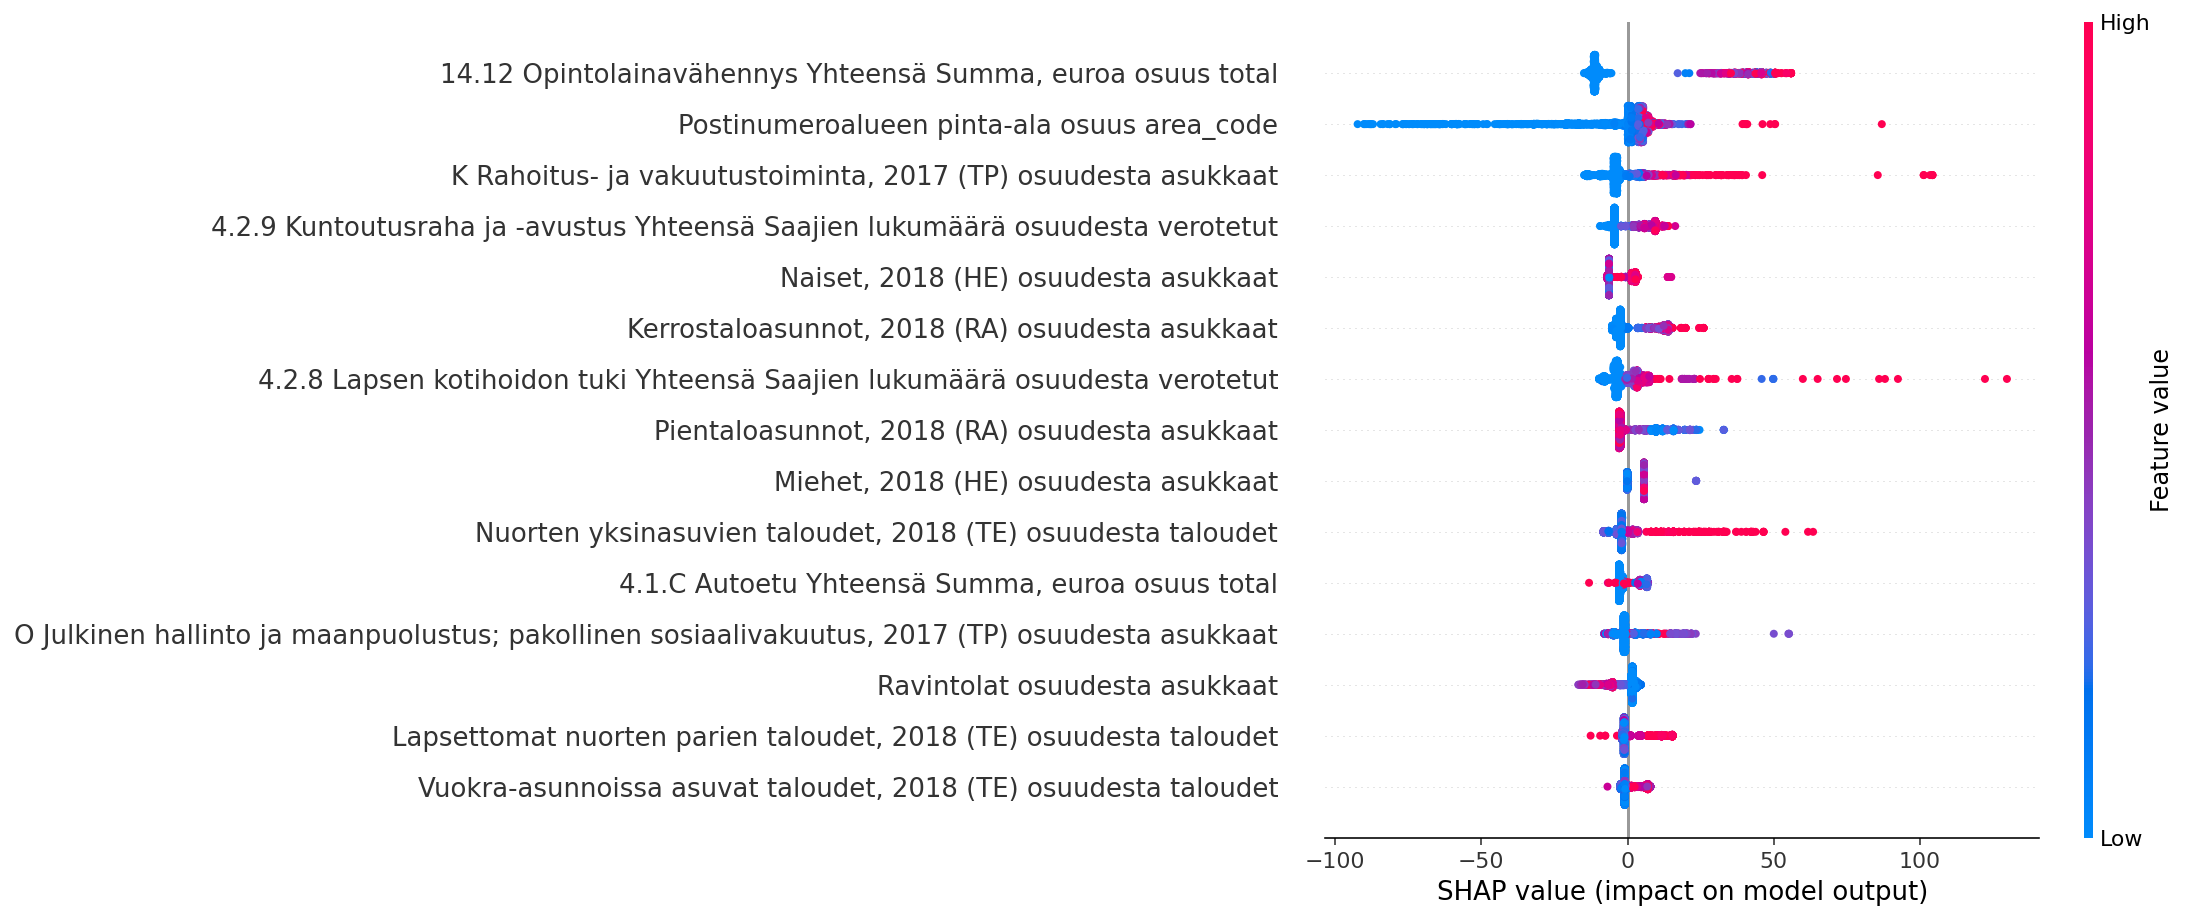

In [20]:
party ='KD'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


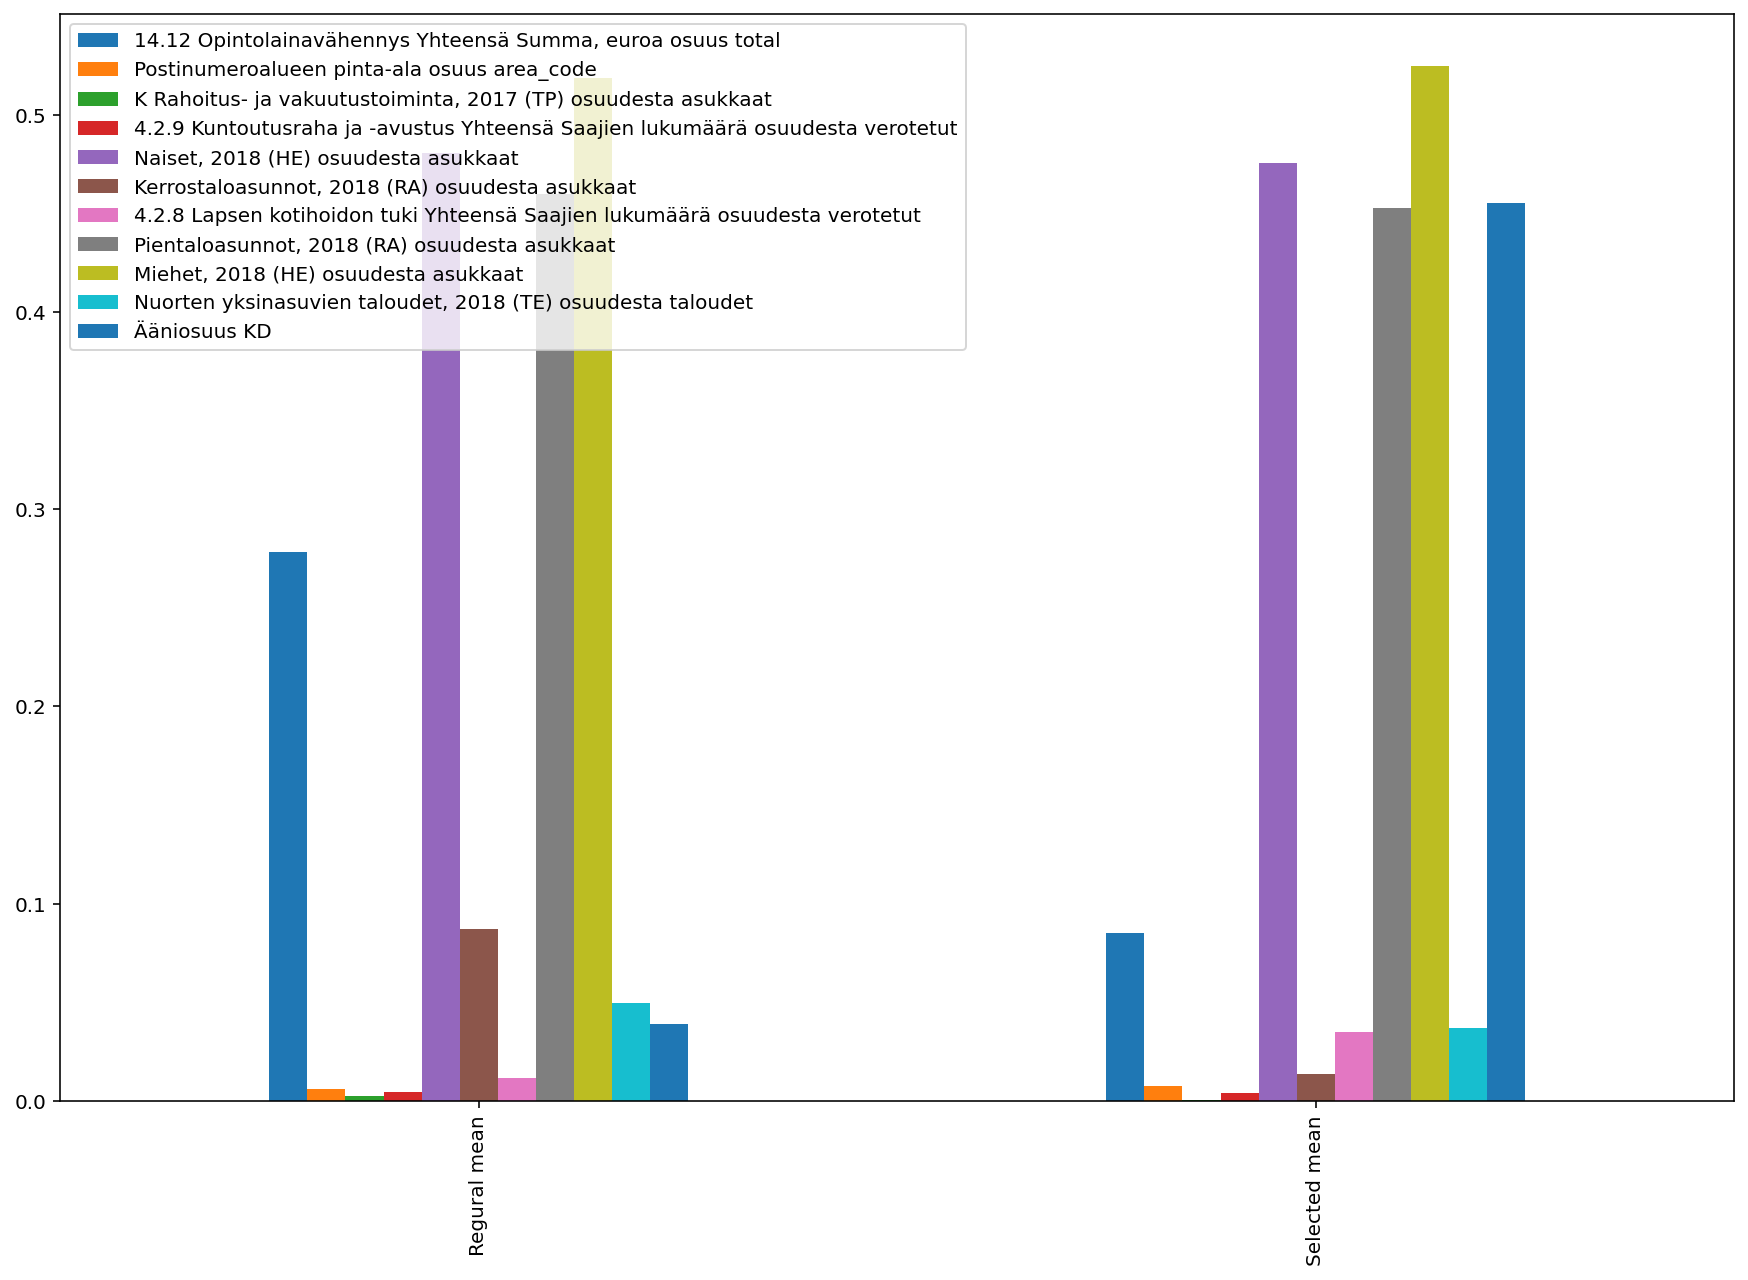

In [21]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [22]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1184       39810    LINNANKYLÄ           Kihniö                         327.0   
1178       39620     KOVESJOKI          Parkano                         182.0   
2025       68580        LARSMO            Luoto                         852.0   
1182       39770    AURESKOSKI          Parkano                          66.0   
2024       68570         LUOTO            Luoto                        2374.0   

     Suurin_puolue  Ääniosuus KD  Naiset, 2018 (HE) osuudesta asukkaat  \
1184            KD      0.280899                              0.483180   
1178            KD      0.443223                              0.456044   
2025            KD      0.422348                              0.496479   
1182            KD      0.465347                              0.515152   
2024           RKP      0.365453                              0.491575   

      Postinumeroalueen pinta-ala osuus area_code  \
1184                                     0.005038   
1178                                     0.011023   
2025                                     0.000399   
1182                                     0.004102   
2024                                     0.007534   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
1184                                         0.000000   
1178                                         0.000000   
2025                                         0.000000   
1182                                         0.000000   
2024                                         0.032435   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
1184                                                       0.000000   
1178                                                       0.000000   
2025                                                       0.000000   
1182                                                       0.000000   
2024                                                       0.002949   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
1184                                                                        0.000000   
1178                                                                        0.000000   
2025                                                                        0.011218   
1182                                                                        0.000000   
2024                                                                        0.006300   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  
1184                                                     0.000000  
1178                                                     0.000000  
2025                                                     0.000000  
1182                                                     0.000000  
2024                                                     1.001447

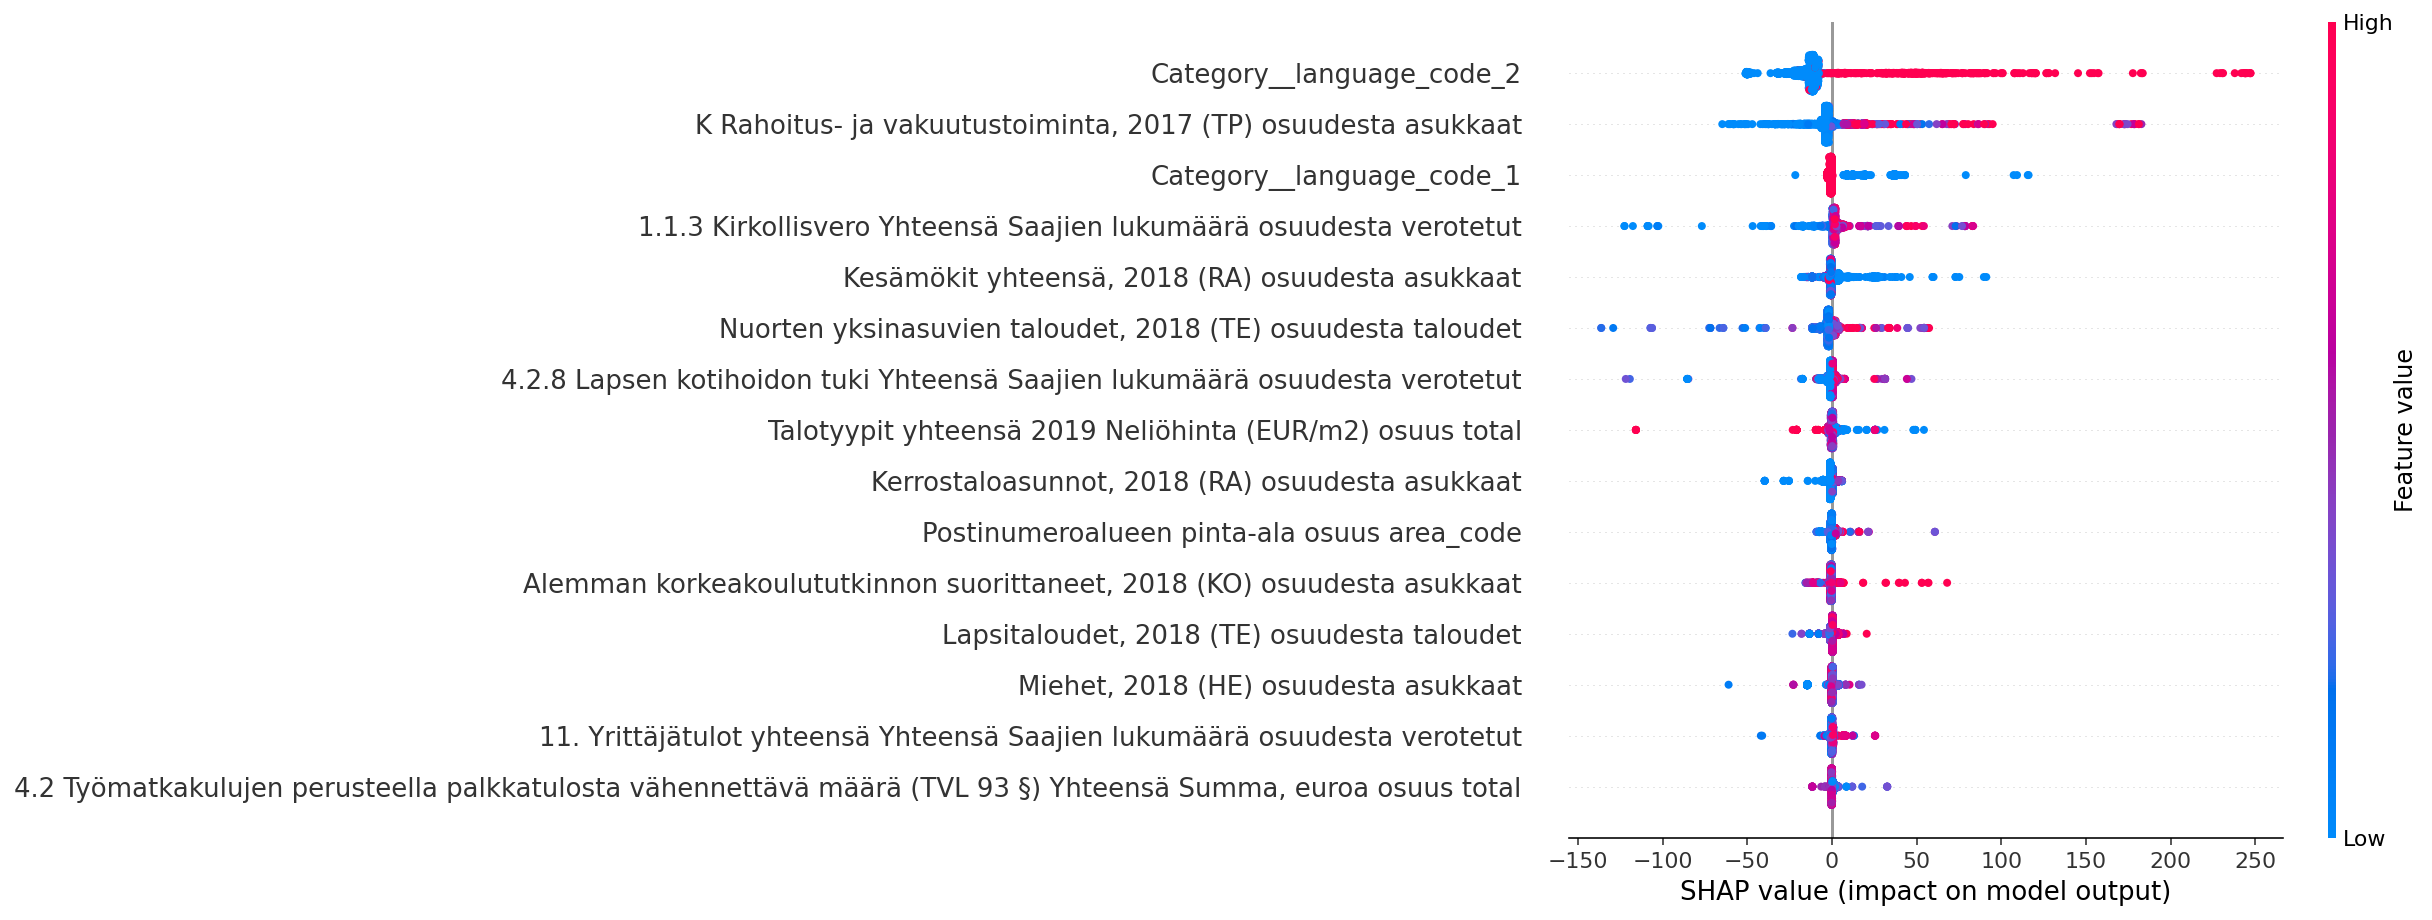

In [23]:
party ='RKP'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


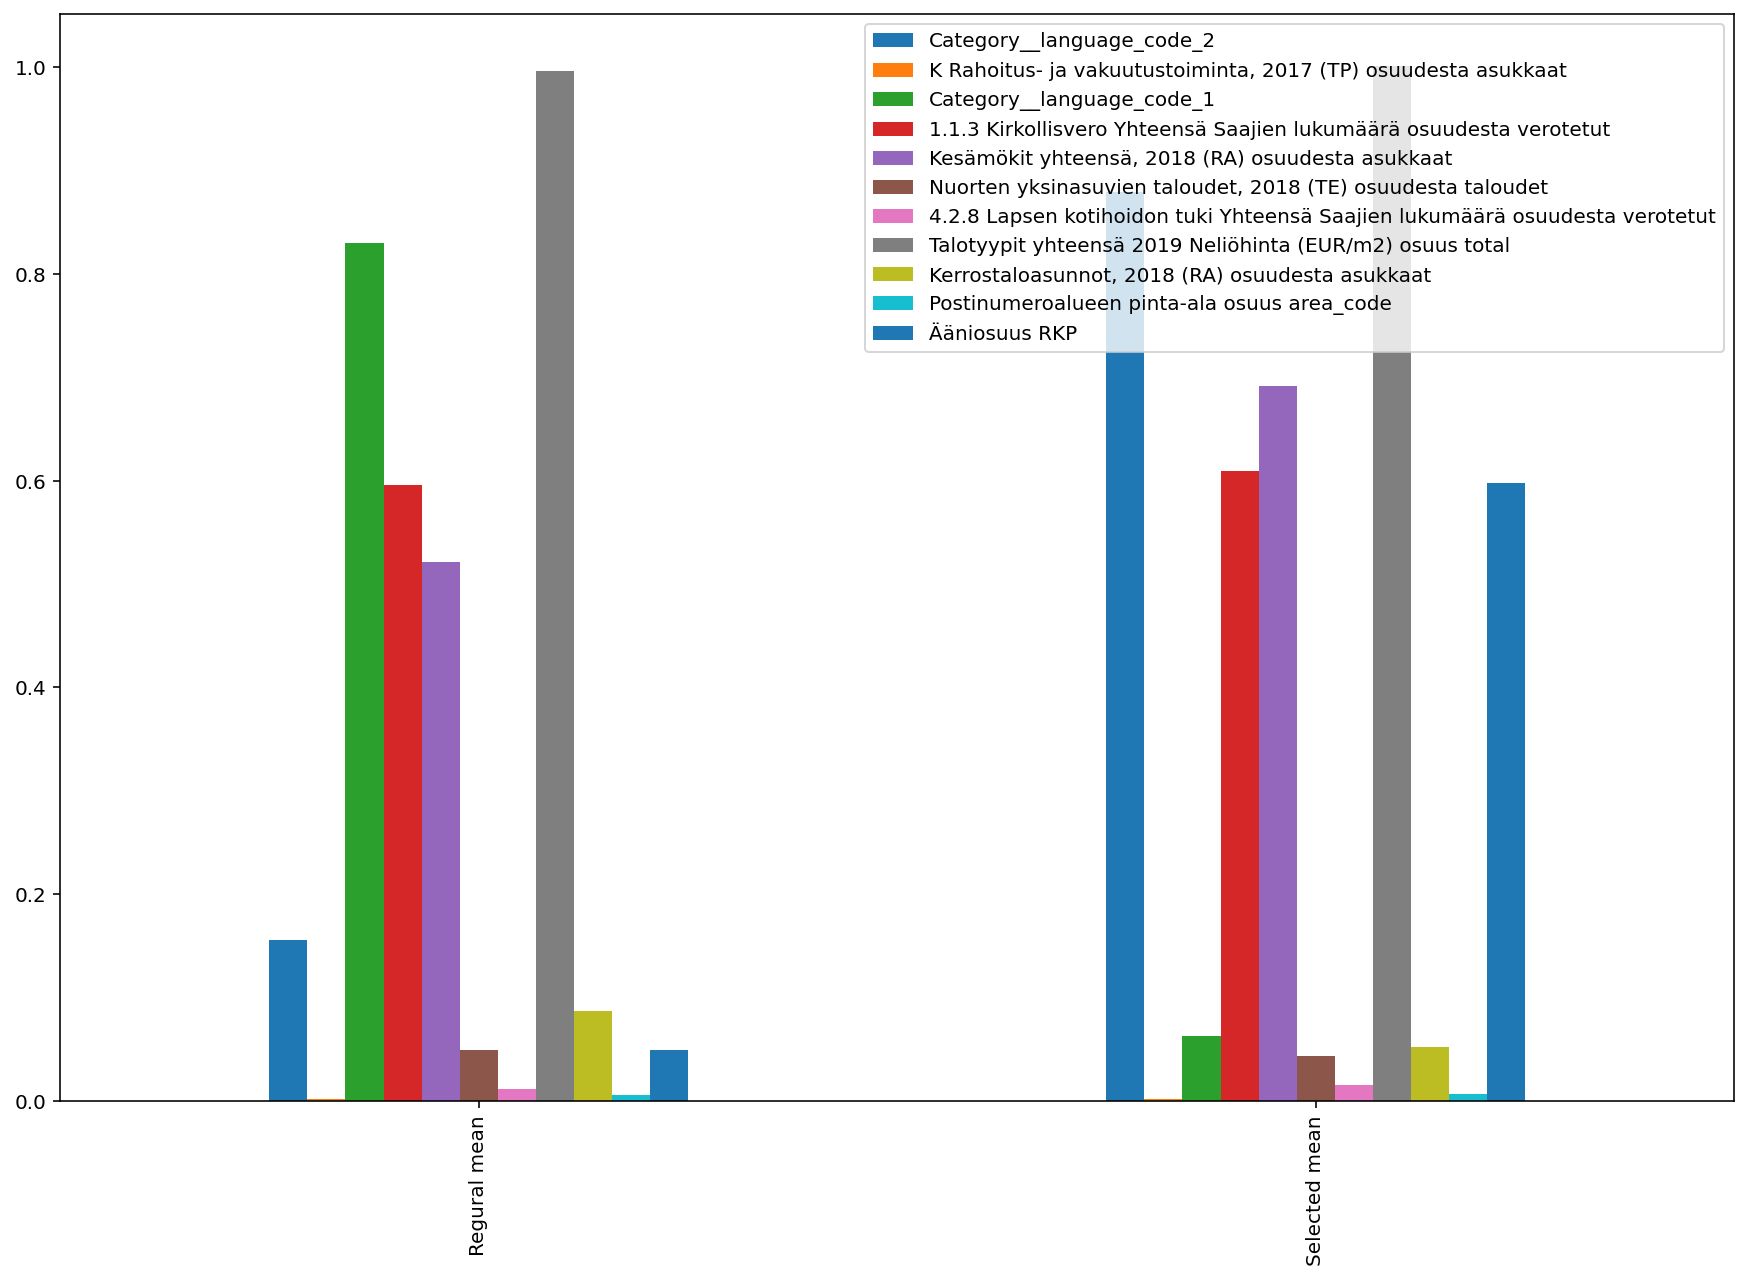

In [24]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [25]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
368        10600    TAMMISAARI        Raasepori                        4846.0   
670        21720    KORPOSTRÖM         Parainen                          20.0   
360        10380   KAUNISLAHTI        Raasepori                         110.0   
1895       64220     YTTERMARK           Närpes                         932.0   
1958       66200       KORSNÄS          Korsnäs                         858.0   

     Suurin_puolue  Ääniosuus RKP  \
368            RKP       0.594726   
670            RKP       0.674419   
360            RKP       0.373737   
1895           RKP       0.891501   
1958           RKP       0.913534   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
368                                           0.569542   
670                                           7.550000   
360                                           0.190909   
1895                                          0.019313   
1958                                          0.291375   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
368                                                        0.018778   
670                                                        0.000000   
360                                                        0.000000   
1895                                                       0.003219   
1958                                                       0.011655   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
368                                                      0.107743   
670                                                      0.000000   
360                                                      0.021277   
1895                                                     0.069825   
1958                                                     0.066852   

      1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut  \
368                                                             0.626064   
670                                                             0.451613   
360                                                             0.549451   
1895                                                            0.648170   
1958                                                            0.594560   

      Category__language_code_1  Category__language_code_2  
368                           0                          1  
670                           0                          1  
360                           0                          1  
1895                          0                          0  
1958                          0                          1

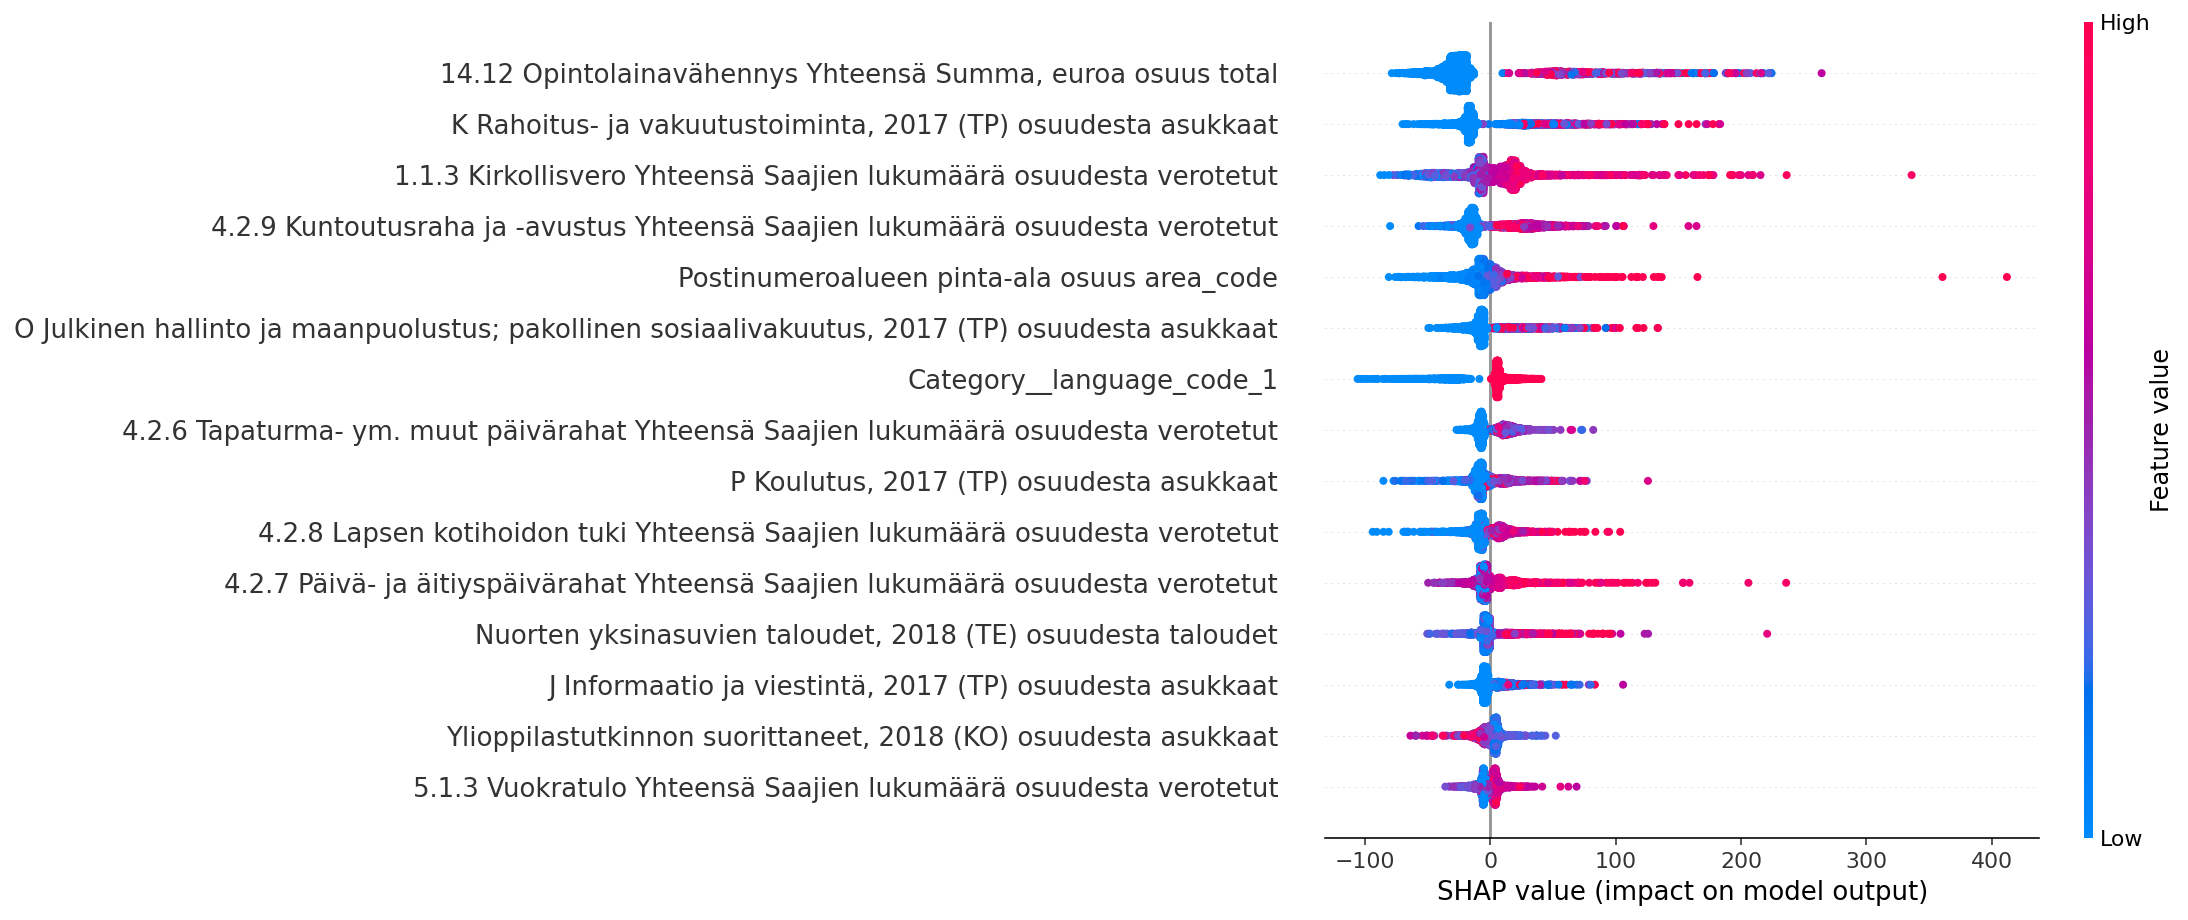

In [26]:
party ='KESK'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


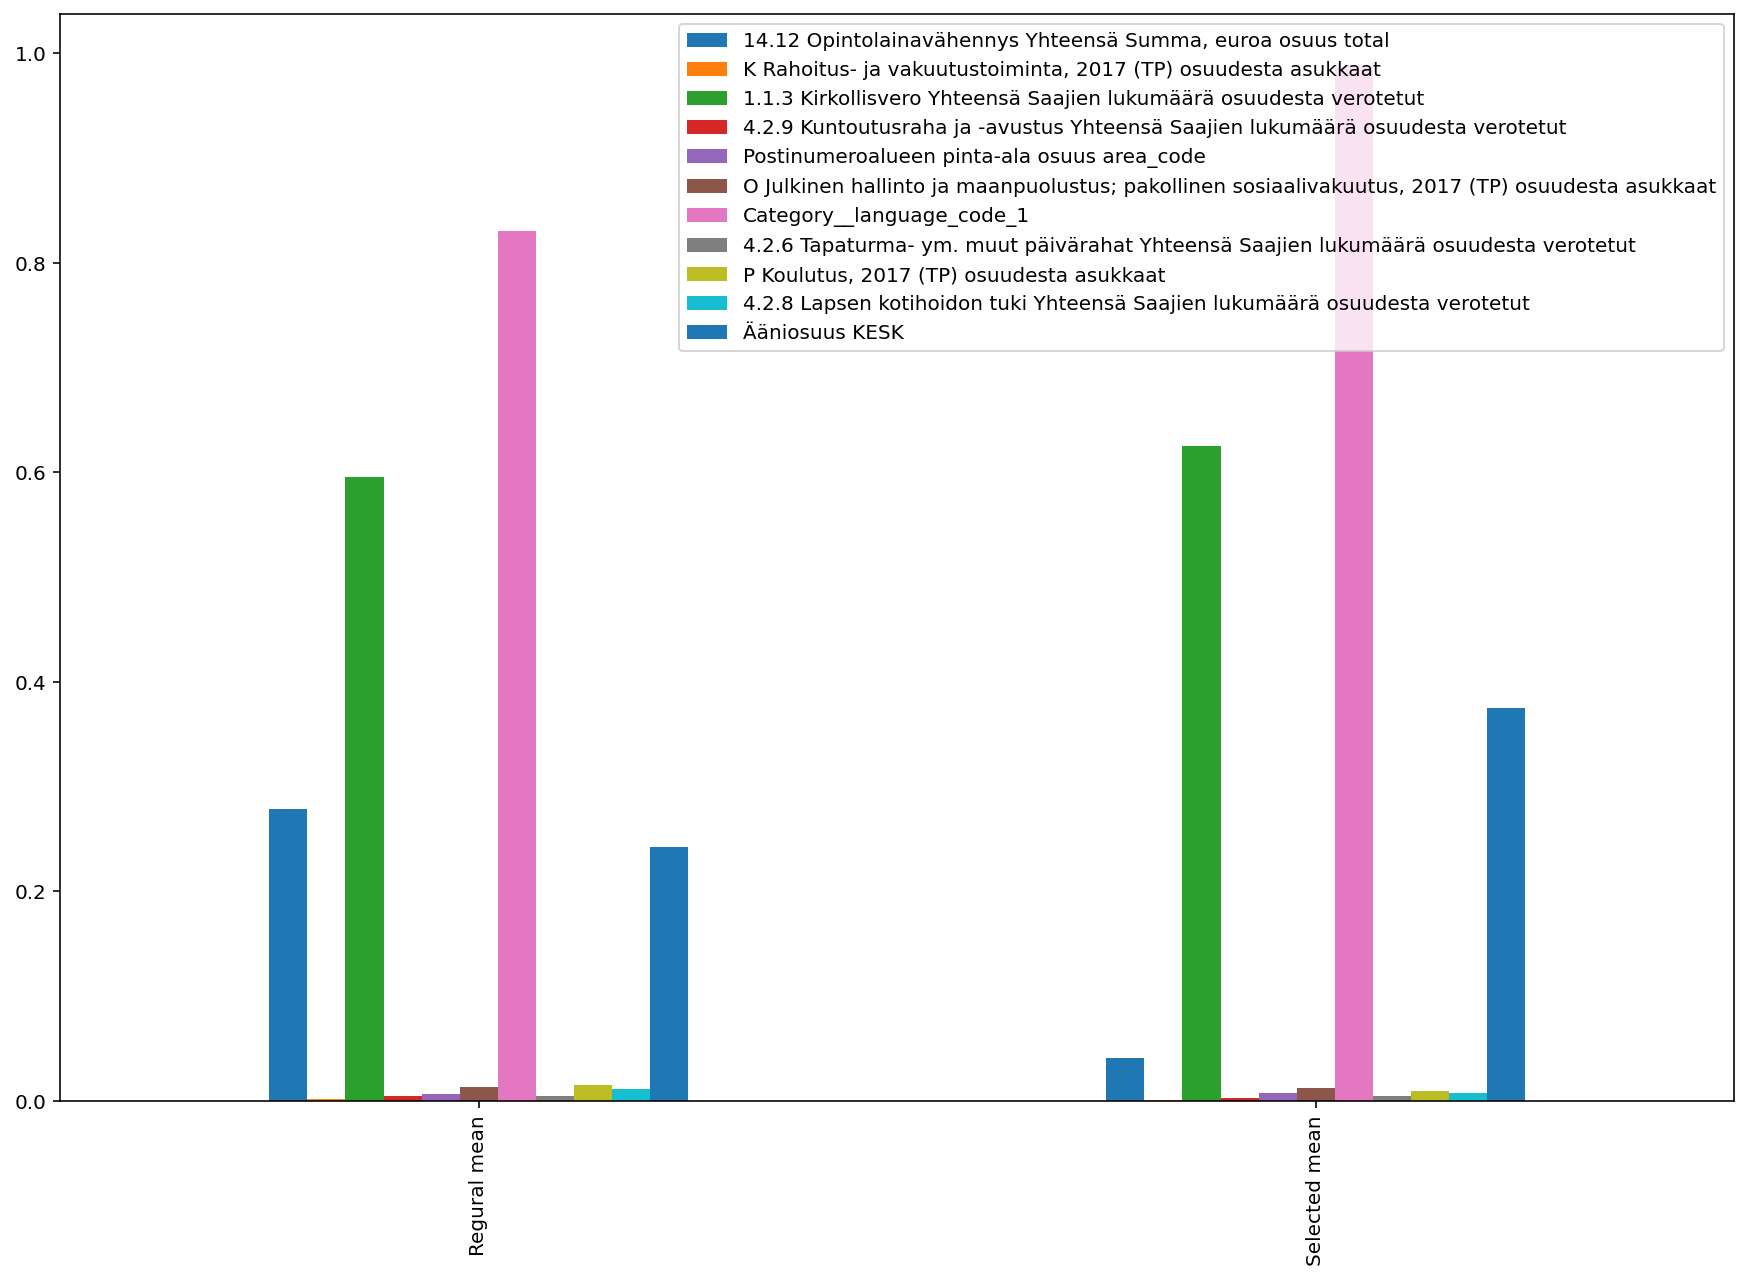

In [27]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [28]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2242       75530        NURMES           Nurmes                        2731.0   
1343       44950   KÄRVÄSJÄRVI       Pihtipudas                         185.0   
2598       90470      VARJAKKA             Oulu                        1157.0   
1372       46730       RUOTILA          Kouvola                         111.0   
1337       44790       KOTVALA       Viitasaari                          43.0   

     Suurin_puolue  Ääniosuus KESK  \
2242          KESK        0.256221   
1343          KESK        0.555556   
2598          KESK        0.339216   
1372          KESK        0.426667   
1337          KESK        0.304348   

      Postinumeroalueen pinta-ala osuus area_code  \
2242                                     0.005010   
1343                                     0.004264   
2598                                     0.000758   
1372                                     0.003627   
1337                                     0.001371   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2242                                                       0.008056   
1343                                                       0.000000   
2598                                                       0.001729   
1372                                                       0.000000   
1337                                                       0.000000   

      O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat  \
2242                                                                                         0.017576   
1343                                                                                         0.000000   
2598                                                                                         0.000000   
1372                                                                                         0.000000   
1337                                                                                         0.000000   

      1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut  \
2242                                                            0.671536   
1343                                                            0.615385   
2598                                                            0.616867   
1372                                                            0.683168   
1337                                                            0.625000   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
2242                                                                        0.013423   
1343                                                                        0.000000   
2598                                                                        0.008434   
1372                                                                        0.000000   
1337                                                                        0.000000   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  
2242                                                     0.296824  
1343                                                     0.000000  
2598                                                     0.000000  
1372                                                     0.000000  
1337                                                     0.000000

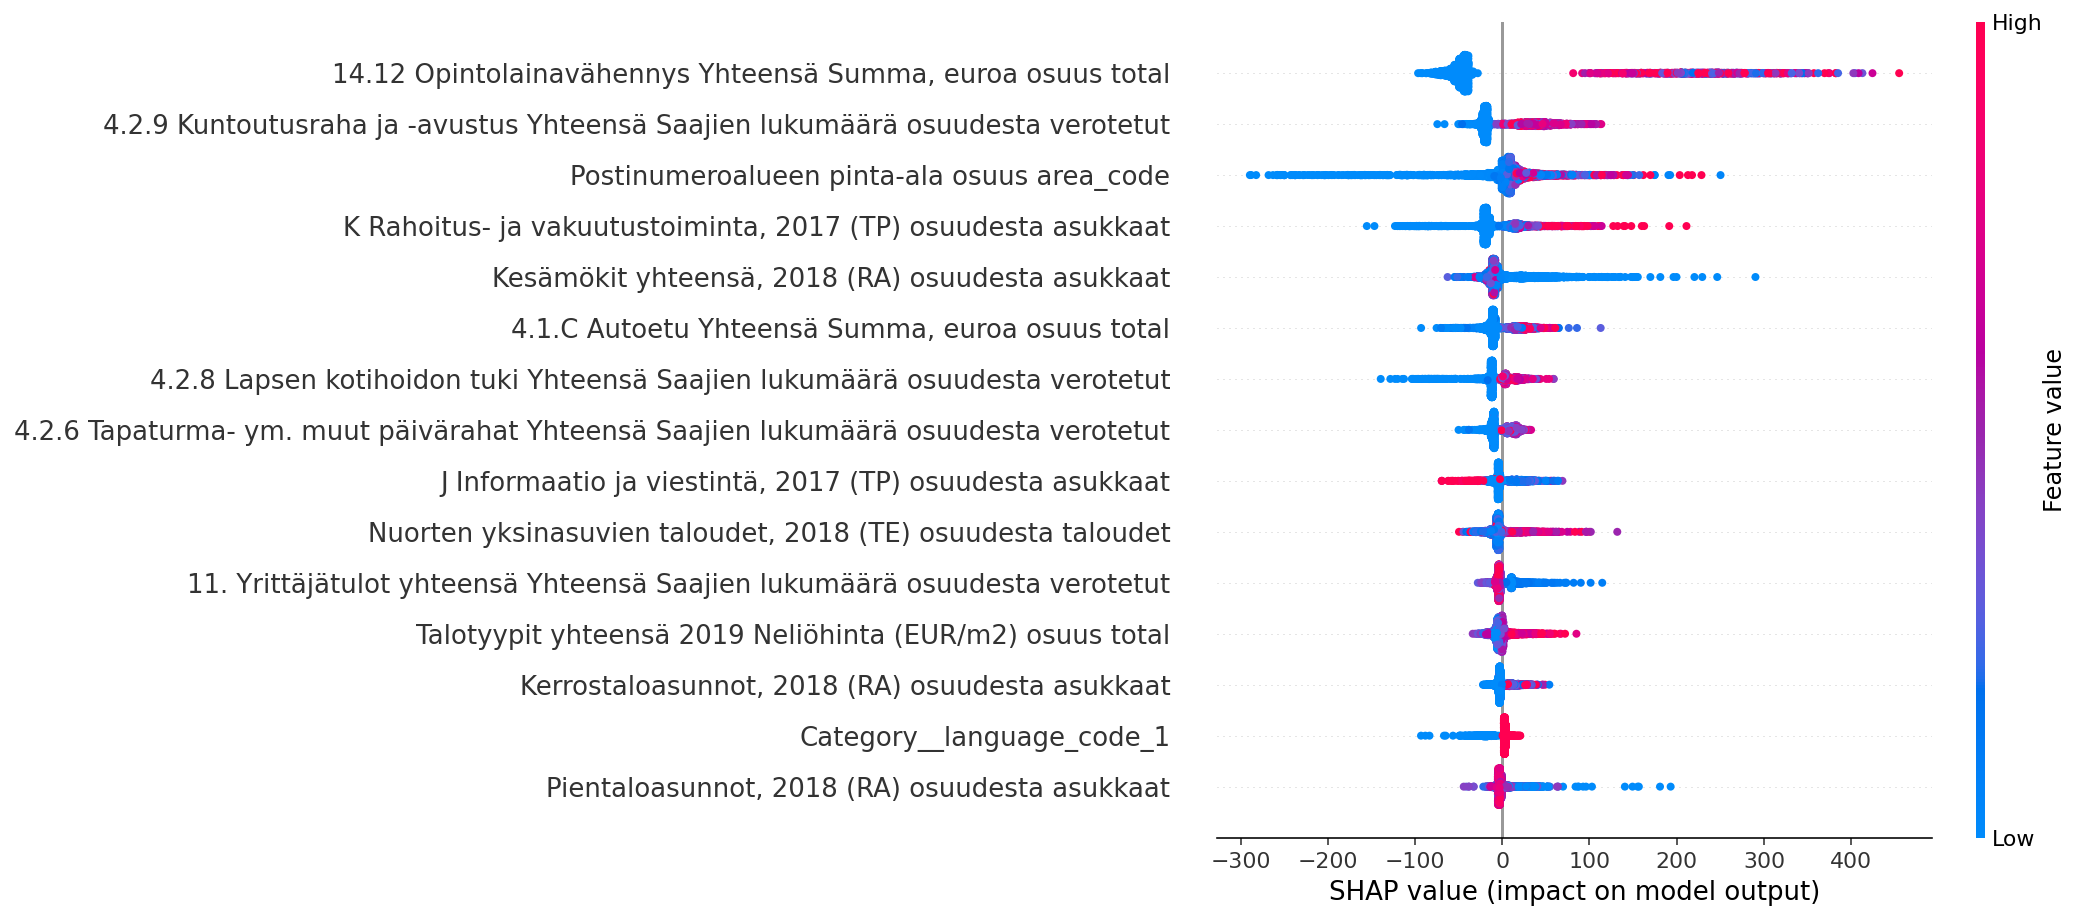

In [29]:
party ='PS'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


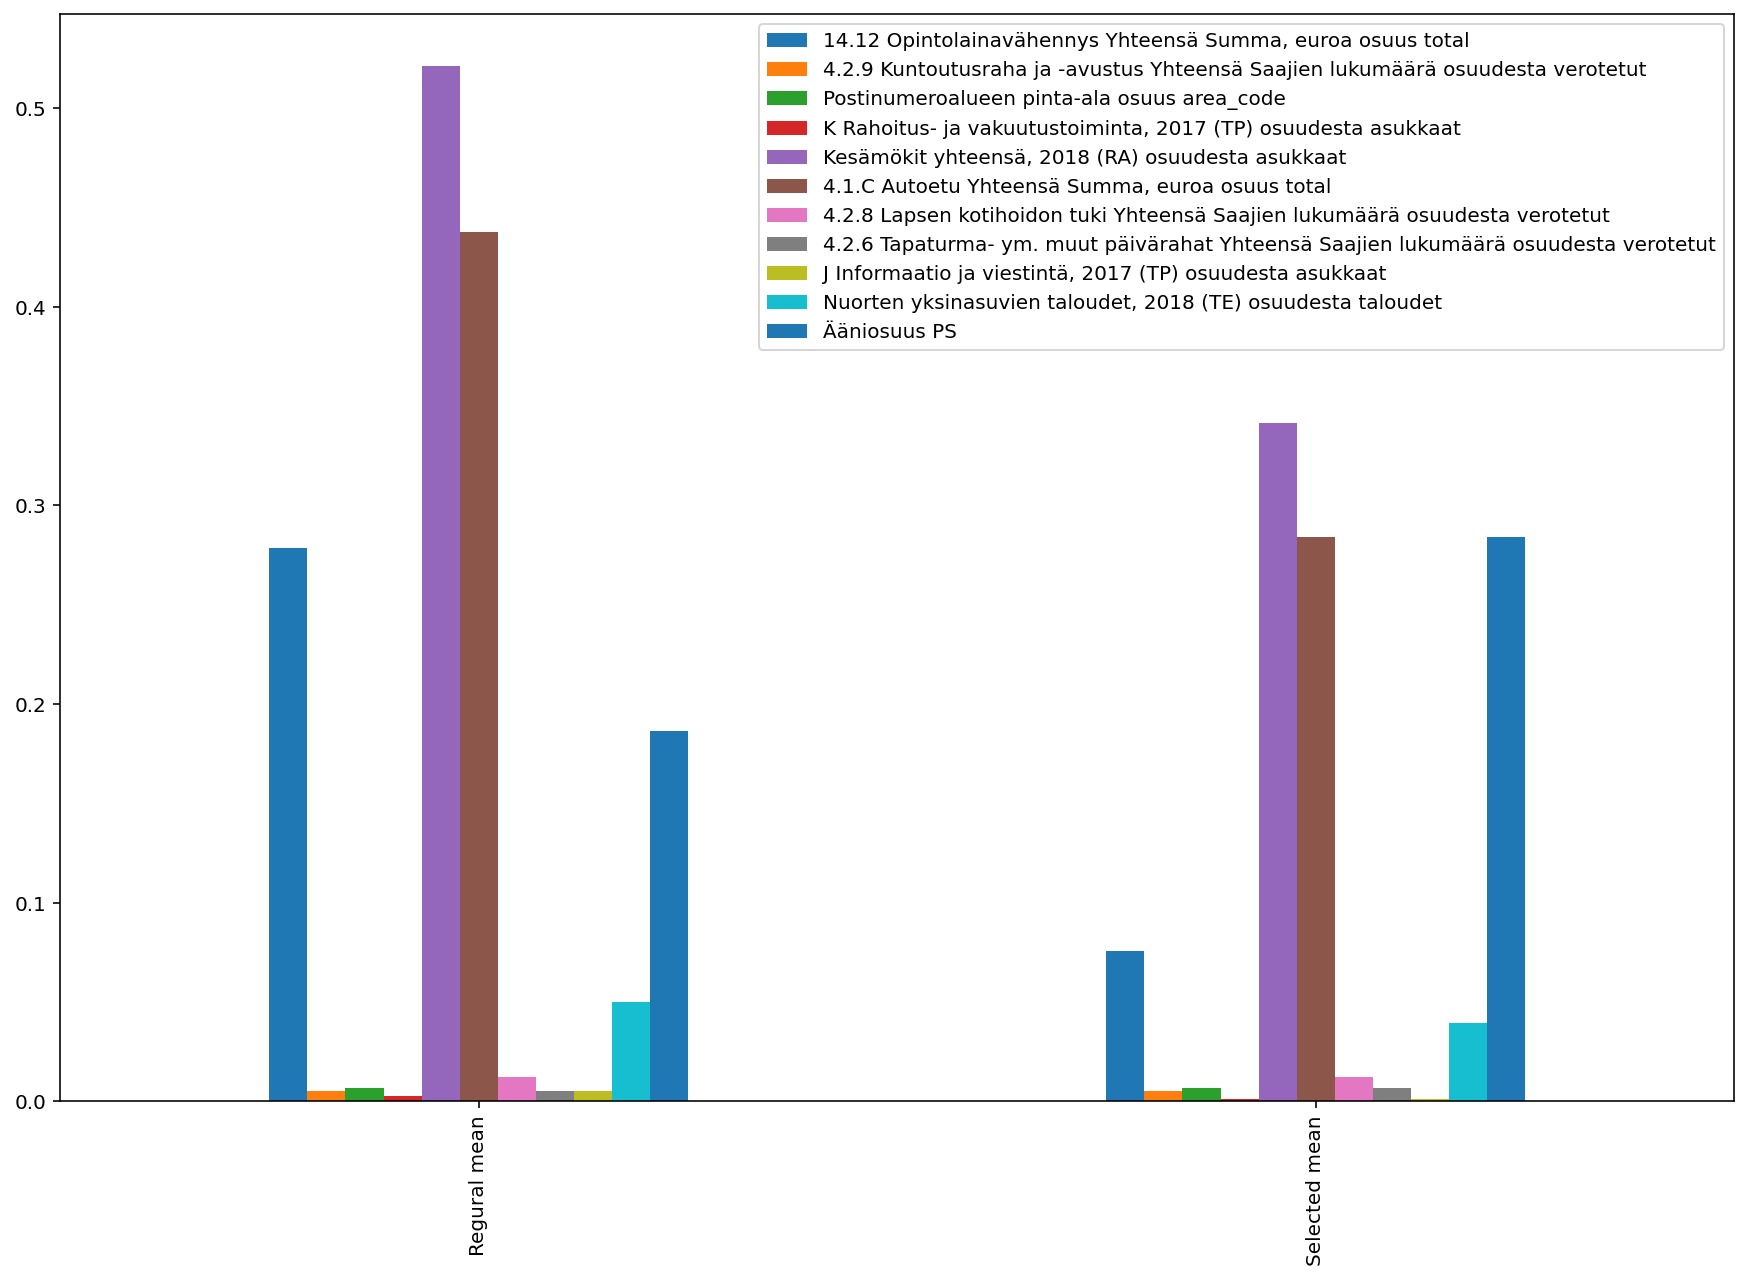

In [30]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [31]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1445       49780       ONKAMAA           Hamina                          89.0   
744        25130        MUURLA             Salo                        1485.0   
652        21370       AURA KK             Aura                         574.0   
1332       44680      LAHNANEN       Viitasaari                          56.0   
2154       71910      ALAPITKÄ       Lapinlahti                         782.0   

     Suurin_puolue  Ääniosuus PS  Postinumeroalueen pinta-ala osuus area_code  \
1445            PS      0.255319                                     0.010098   
744             PS      0.262916                                     0.007734   
652             PS      0.272265                                     0.002968   
1332          KESK      0.261905                                     0.003380   
2154          KESK      0.273381                                     0.004794   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
1445                                          1.067416   
744                                           0.184512   
652                                           0.054007   
1332                                          1.142857   
2154                                          0.280051   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
1445                                                        0.00000   
744                                                         0.00202   
652                                                         0.00000   
1332                                                        0.00000   
2154                                                        0.00000   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
1445                                                                        0.000000   
744                                                                         0.010317   
652                                                                         0.000000   
1332                                                                        0.000000   
2154                                                                        0.012800   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  \
1445                                                          0.0   
744                                                           0.0   
652                                                           0.0   
1332                                                          0.0   
2154                                                          0.0   

      4.1.C Autoetu Yhteensä Summa, euroa osuus total  
1445                                         0.000000  
744                                          0.000000  
652                                          1.220671  
1332                                         0.000000  
2154                                         0.000000

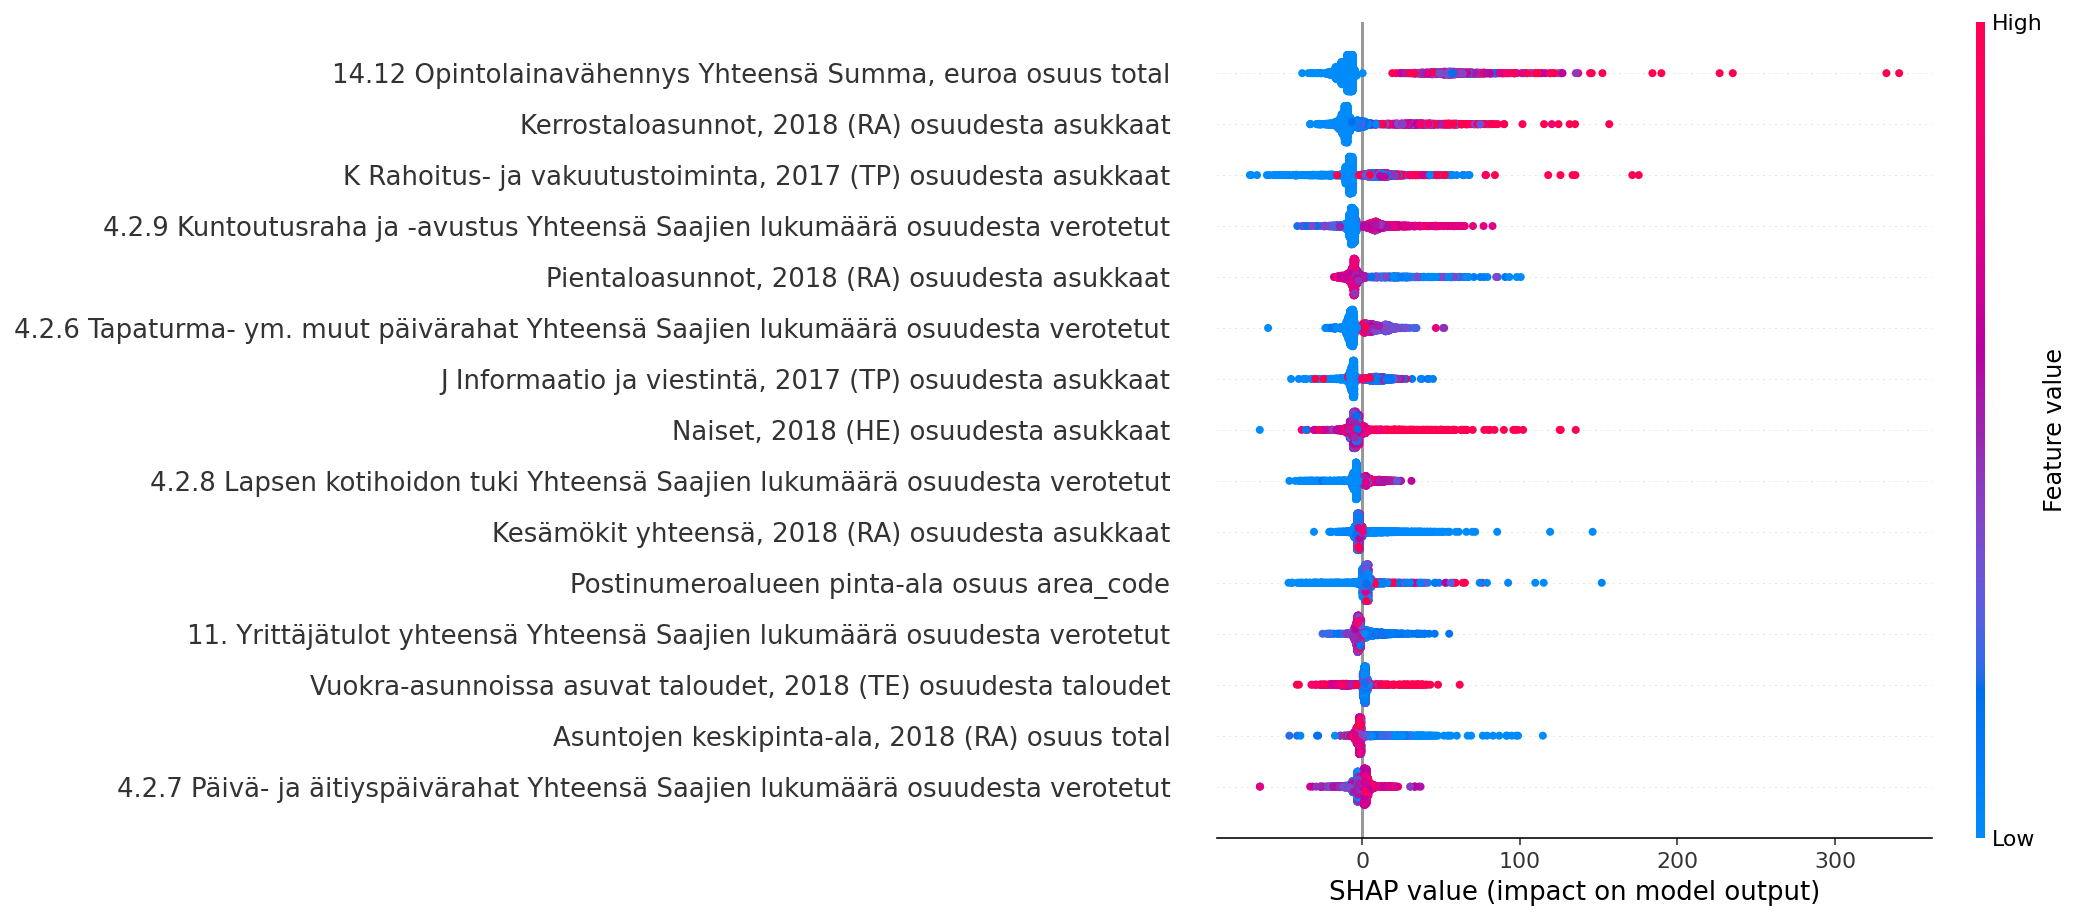

In [32]:
party ='VAS'
aaniosuus = 'Ääniosuus ' + party
shap_index = list_of_parties.index(party)
included_columns = aaniosuus
compare_to = data[(data[aaniosuus]) > 0.25].copy()

shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


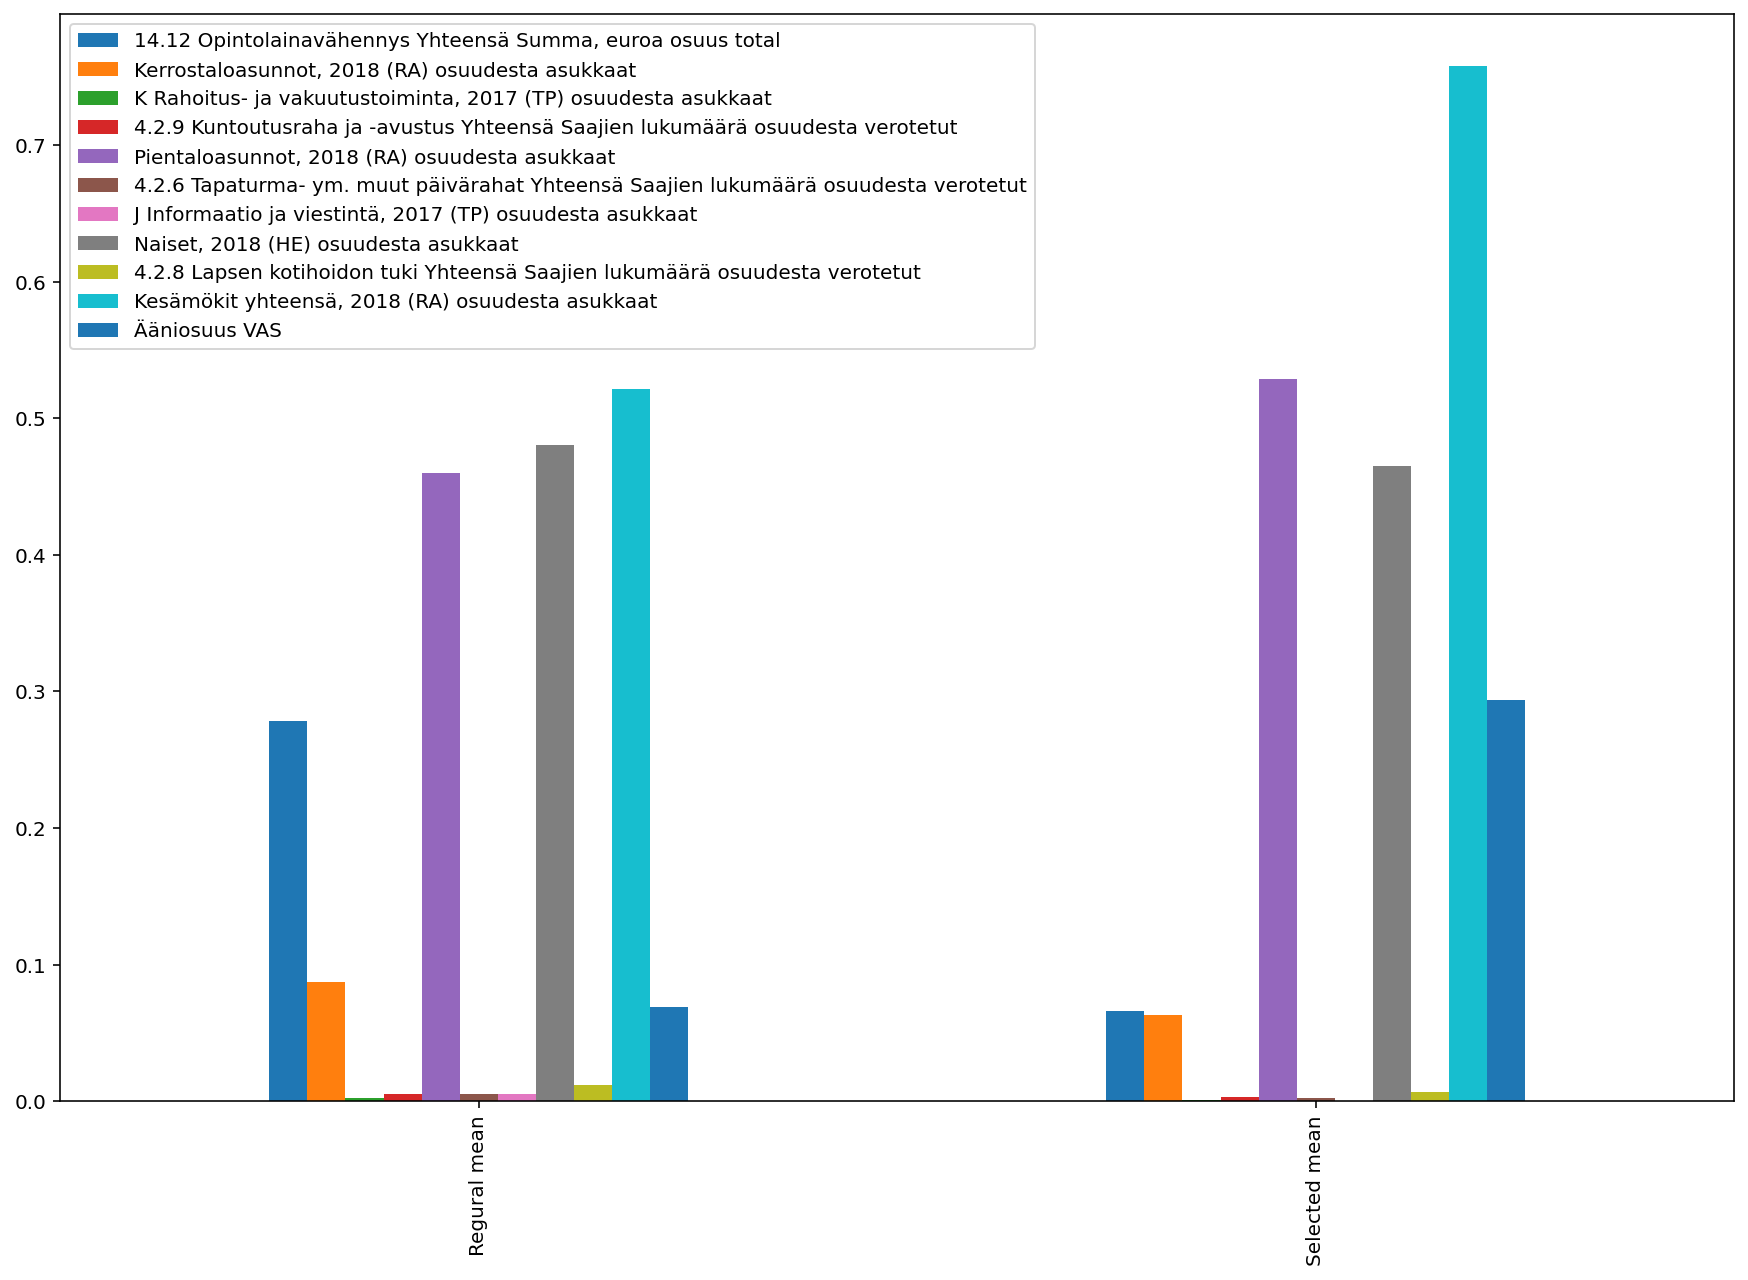

In [33]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=10, scaled=False)

In [34]:
    new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
    new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=6)
    new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2568       89440        SAKARA      Suomussalmi                          87.0   
2510       86850   HIIDENNIEMI        Pyhäjärvi                         228.0   
1312       44260     VIHIJÄRVI        Äänekoski                         277.0   
2572       89660        TAKALO      Suomussalmi                         104.0   
2778       95860    PASMAJÄRVI           Kolari                          32.0   

     Suurin_puolue  Ääniosuus VAS  \
2568          KESK       0.271845   
2510          KESK       0.278169   
1312           VAS       0.250712   
2572          KESK       0.274194   
2778           VAS       0.303030   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
2568                                              0.0   
2510                                              0.0   
1312                                              0.0   
2572                                              0.0   
2778                                              0.0   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
2568                                       0.482759   
2510                                       0.504386   
1312                                       0.458484   
2572                                       0.586538   
2778                                       0.687500   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2568                                                            0.0   
2510                                                            0.0   
1312                                                            0.0   
2572                                                            0.0   
2778                                                            0.0   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
2568                                                                                  0.0   
2510                                                                                  0.0   
1312                                                                                  0.0   
2572                                                                                  0.0   
2778                                                                                  0.0   

      4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut  \
2568                                                                             0.0   
2510                                                                             0.0   
1312                                                                             0.0   
2572                                                                             0.0   
2778                                                                             0.0   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  
2568                                                          0.0  
2510                                                          0.0  
1312                                                          0.0  
2572                                                          0.0  
2778                                                          0.0

In [35]:
from show_election_result import show_election_result
show_election_result(data, vaalidata, target_col_start, list_of_parties)

VIHR  lasketut äänet: Aitotulos  354152 Laskennallinen  344923 Ennuste  336235
Laskennallisen virhe aitoon tulokseen 2.606 %
Ennusteen virhe aitoon tulokseen 5.059 %
Ennusteen virhe laskennalliseen tulokseen 2.519 %

KOK  lasketut äänet: Aitotulos  523924 Laskennallinen  514711 Ennuste  516345
Laskennallisen virhe aitoon tulokseen 1.758 %
Ennusteen virhe aitoon tulokseen 1.447 %
Ennusteen virhe laskennalliseen tulokseen -0.317 %

SDP  lasketut äänet: Aitotulos  546263 Laskennallinen  538953 Ennuste  545022
Laskennallisen virhe aitoon tulokseen 1.338 %
Ennusteen virhe aitoon tulokseen 0.227 %
Ennusteen virhe laskennalliseen tulokseen -1.126 %

KD  lasketut äänet: Aitotulos  120019 Laskennallinen  117310 Ennuste  118643
Laskennallisen virhe aitoon tulokseen 2.257 %
Ennusteen virhe aitoon tulokseen 1.147 %
Ennusteen virhe laskennalliseen tulokseen -1.136 %

KESK  lasketut äänet: Aitotulos  423511 Laskennallinen  415388 Ennuste  414784
Laskennallisen virhe aitoon tulokseen 1.918 %
Ennustee

Yksittäinen pnro

In [36]:
pnro = '00100'
id_col = 'Postinumero'
party ='KOK'
key = 'Äänet yhteensä lkm ' + party
idx = data[data[id_col]==pnro].index.item()
prt_number = list_of_parties.index(party)

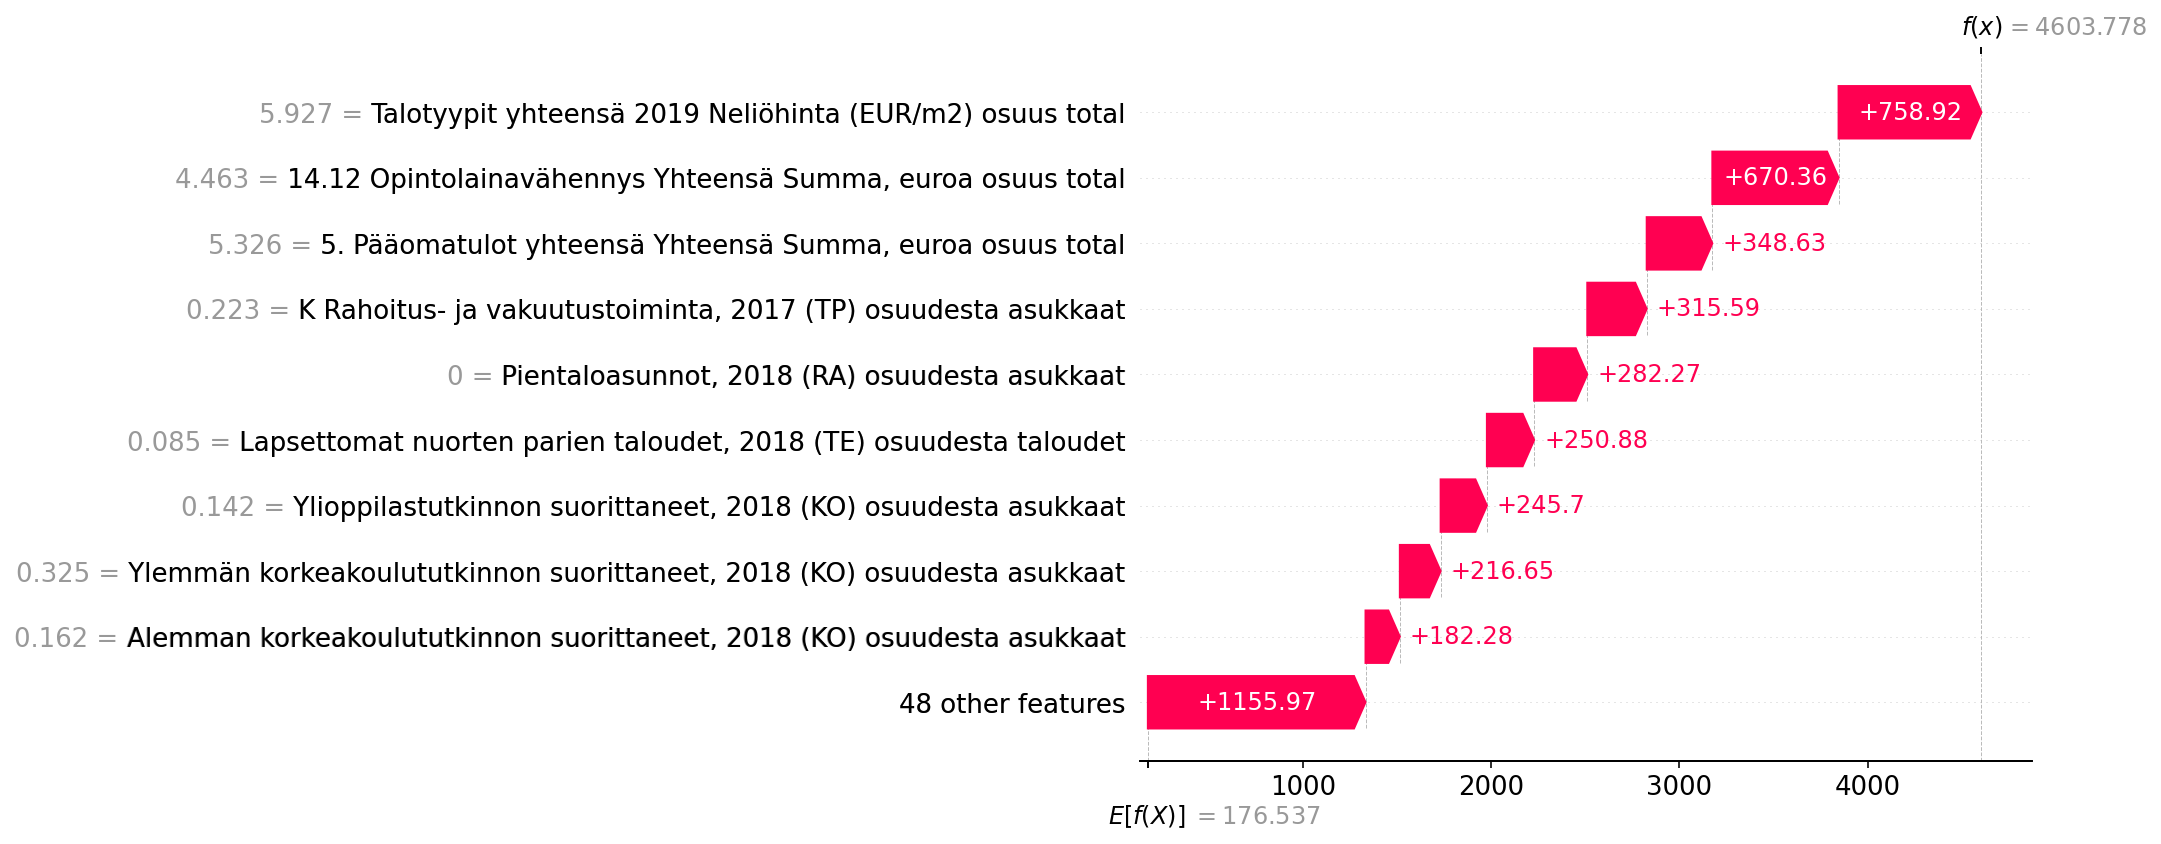

In [37]:
shap.waterfall_plot(shap_expected_value[prt_number], shap_values[prt_number][idx], X.iloc[idx,:], max_display=10)